<a href="https://colab.research.google.com/github/bentson1187/dsc-phase-4-project/blob/main/Phase_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project Submission

* Student name: **Brian Bentson**
* Student pace: self paced / part time / full time: **Full Time**
* Scheduled project review date/time: 6/23/21 @ 2pm CST
* Instructor name: **James Irving**
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

# Table of Contents

*Click to jump to matching Markdown Header*

- **[INTRODUCTION](#INTRODUCTION)**<br>
- **[DATA COLLECTION](#DATA-COLLECTION)**<br>
- **[DATA CLEANING](#DATA-CLEANING)**<br>
- **[DATA EXPLORATION](#DATA-EXPLORATION)**<br>
- **[DATA MODELING](#DATA-MODELING)**<br>
- **[DATA INTERPRETATION](#DATA-INTERPRETATION)**<br>
- **[RECOMMENDATIONS AND CONCLUSIONS](#RECOMMENDATIONS-AND-CONCLUSIONS)**

# INTRODUCTION

HIT Investments is looking to leverage advanced analytics to aid in their decision-making process of identifying high-value, low cost stocks to invest in for their clients. Their specialty is finding and investing in micro-cap stocks which have been undervalued by others but otherwise show strong financial metrics. 

Historically, HIT Investments has leveraged their expertise to determine a Value Ranking of these stocks which takes into account multiple financial performance metrics. This analysis will take the next step and investigate how the top value stocks are projected to grow into the future to help further aid in their decision to buy a stock. 

## Business Statement

HIT Investments strives to maximize after-tax returns for their clients by actively identifying and capitalizing on proven inefficiencies in the stock market using quantitative analysis. 

A market is said to be "efficient" if the price of a stock reflects all available and relevant information. This theory holds true for larger companies that are thoroughly tracked by investment firms. However, HIT Investments believes the market has inefficiencies, specifically in the Micro-Cap segment, which can be exploited to outpeform the stock market and deliver maximum return on investment. Micro-Cap companies have a total market cap of between \$50M and \$300M. Micro-Cap stocks encompass more than one-half of the nationally traded companies so there are many opportunities to examine these stocks for value and growth potential. 

This analysis will investigate stocks from the [FMP](https://financialmodelingprep.com/) API, rank the stocks based on HIT Investments' "value" metrics and then forecast future growth of the top value stocks. This will provide HIT Investments with a new "growth" metric to utilize alongside the "value" metric to further quantify which stocks may be inefficient, are growing and therefore provide value to an investor.



 

## Analysis Methodology

This analysis will examine stocks based on 5 key performance metrics that define its' "value":
- Price to Earnings Ratio (`pe_ratio`): $\dfrac{Stock Price}{Company Earnings}$
- Enterprise Value to Operating Cashflow (`ev_to_operating_cashflow`): $\dfrac{Market Cap +Total Debt − Cash}{Operating Cashflow}$
- Enterprise Value Over EBITDA (`enterprise_value_over_EBITDA`): $\dfrac{Market Cap +Total Debt − Cash}{Earnings Before Interest, Taxes, Depreciation and Amortization}$
- Enterprise Value to Free Cashflow (`ev_to_free_cashflow`): $\dfrac{Market Cap +Total Debt − Cash}{Free Cashflow}$
- Price to Sales Ratio (`price_to_sales_ratio`): $\dfrac{Market Value per Share}{Sales per Share}$

The stocks will then be ranked comparitively based on these value metrics. For the top "value" stocks, the historical performance on reveneue per share (`revenue_per_share`) will be analyzed and modeled to forecast future growth. This will produce a second ranking of stocks based soley on growth. Lastly, the "Value" and "Growth" rankings will be consolidated in order to 

To simplify the analysis, I will perform the value rankings first and will delete the `date` feature in order to remove duplicate values for the `symbol_id`. Once the top "value" stocks are identified, I will bring the `date` feature back in to model and forecast the `revenue_per_share`. 

# DATA COLLECTION

## Import Packages

In [424]:
#install pmdarima
!pip install pmdarima

In [425]:
#data wrangling and visualization packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import scipy.stats as stats

#feature engineering packages
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

#modeling packages
from pmdarima import auto_arima
from statsmodels.tsa import api as tsa
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
#modeling evaluation packages
from statsmodels.tools.eval_measures import rmse

In [426]:
#notebook settings
pd.set_option("display.max_columns", 40)
pd.options.display.float_format = '{:,}'.format

from pylab import rcParams
rcParams['figure.figsize'] = 18,6

import warnings
warnings.filterwarnings('ignore')

## Global Functions

In [427]:
def col_eval(df, num_col=None, cat_cols=None, label_count=25, thresh=0.025):
    '''
    This function evaluates a single numeric feature or a list of categorical 
    features for feature engineering. It takes in a dataframe, a feature(s)
    and provides detailed descriptive statistics and draws 4 informative graphs. 
    Keyword Arguments:
    - df -- A dataframe
    - num_col -- A single column of numeric data (default=None)
    - cat_cols -- A list of categorical columns (default=None)
    - label_count -- Number of labels to draw in bar graph (default=25)
    - thresh -- A threshold line drawn on the bar graph to indicate percentage 
    (default = 0.025)
    '''
    if num_col != None:
        #print the column name
        print(f'Column Name: {num_col}')
        #print the number of unique values
        print(f'Number of unique values: {df[num_col].nunique()}')
        #print the number of duplicate values
        print(f'There are {df[num_col].duplicated().sum()} duplicates')
        #print the number of null values
        print(f'There are {df[num_col].isna().sum()} null values')
        #print the number of negative values
        print(f'There are {(df[num_col] < 0).sum()} negative values')
        print('\n')
        #print descriptive statistics
        print('Descriptive Metrics:','\n',
              df[num_col].describe())
        #plot boxplot, histogram         
        fig, ax = plt.subplots(ncols=2, figsize=(15,10))
        
        histogram = df[num_col].hist(ax=ax[0])
        ax[0].set_title(f'Distribution of {num_col}');
        
        boxplot = df.boxplot(column=num_col, ax=ax[1]);
        ax[1].set_title(f'Boxplot of {num_col}');

        plt.tight_layout()

        plt.show()
        print('\n')
        
        return
    
    else:
        
        for col in cat_cols:
            print('=============================================================')
            #print the column name
            print(f'Column Name: {col}')
            print('\n')
            #print the number of unique values
            print(f'Number of unique values: {df[col].nunique()}')
            print('\n')
            #print the number of duplicate values
            print(f'There are {df[col].duplicated().sum()} duplicates')
            print('\n')
            #print the number of null values
            print(f'There are {df[col].isna().sum()} null values')
            print('\n')
            #print the number of values equal to '0'
            print(f'There are {(df[col] == "0").sum()} zeros')
            print('\n')
            #print the value counts percentage
            print('Value Counts Percentage', '\n', 
                  df[col].value_counts(dropna=False).round(2))
            print('\n')

            #plot barplot, histogram         
            fig, ax = plt.subplots(figsize=(15,10))

            bar_graph = df[col].value_counts(normalize=True, 
                                             dropna=False)[:label_count].plot.bar(label=f'{col} Percentage')
            ax.axhline(y=thresh, color='red', linestyle='--', 
                        label=f'{thresh*100}% Threshold')
            ax.set_title(f'{col} Value Counts')
            ax.set_xlabel(f'{col} Labels')
            ax.set_ylabel('Percentage')
            ax.legend()

            plt.tight_layout()

            plt.show()
        return

In [428]:
def timeseries_creation(df, symbol_id):
  '''
  This function creates a timeseries dataframe and plots it.

  Keyword arguments:
  df -- Timeseries dataframe
  symbol_id -- The symbol_id to create timeseries from
  '''
  #create dataframe
  df = df.loc[df['symbol_id'] == symbol_id]
  df.sort_index(inplace=True)
  display(df)

  #plot 
  df['revenue_per_share'].plot(legend=True);
  plt.title(f"{df['company_name'][0]}")
  plt.ylabel('Revenue Per Share')

  return df

In [429]:
def seasonality_stationarity_check(series, decomp_model='add'):
    """
    This function takes in a time series and returns a seasonal decompose to check
    for seasonality and the result of the Augmented Dickey-Fuller Test to check 
    for stationarity
    
    Keyword arguments:
    series -- Timeseries series
    decomp_model -- Whether to utilize addition or multiplication decomposition
    (default='add')
    """
    result = seasonal_decompose(series, model=decomp_model)
    result.plot();
    plt.show()
    
    print('Augmented Dickey-Fuller Test Results')
    #run the test
    result = adfuller(series.dropna(),autolag='AIC')
    
    #create labels for the results
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    output = pd.Series(result[0:4],index=labels)
    
    #print the results
    print(output.to_string())
    print('\n')
    if result[1] <= 0.05:
        print("The data is stationary")
        
    else:
        print("The data is not stationary")

In [430]:
def create_eval_model(df, ts_col, test_size=5, start_p=0, start_q=0, d=None, 
                      seasonal=False, m=1, trace=False, train_whole=False,
                      plot_diagnostics=False, auto=True, order=None, 
                      seasonal_order=None):
  '''
  This function takes in a timeseries dataframe, splits the timeseries into 
  train and test and uses either the auto-arima function or user defined order 
  parameters to determine the best model. The model then gets fit, plotted, 
  and evaluated using Mean Squared Error.

  Keyword arguments:
  df -- Timeseries dataframe
  t_col -- Column with timeseries info
  test_size -- Size of the test set in years (default = 5)
  start_p -- Begining value of p (AR component of auto-arima) (default = 0)
  start_q -- Begining value of q (AR component of auto-arima) (default = 0)
  d -- The differencing value to apply to the timeseries (default = None)
  seasonal -- Whether the timeseries has a seasonal component to it (default = False)
  m -- The period for seasonal differencing, m refers to the number of
  periods in each season (default = 1)
  trace -- Show stepwise search of ARIMA models (default = False)
  train_whole -- Whether or not to train the model on the entire timeseries or 
  just the training set. (default = False)
  plot_diagnostics -- Whether or not to plot model diagnostic plots (default = False)
  auto -- Whether or not to utilize auto-arima to find the best mode (default = True)
  order -- Order parameters specified by user (default = None)
  seasonal_order -- Seasonal order parameters specified by user (default=None)
  '''
  
  #train-test split
  train = df.iloc[:-test_size]
  test = df.iloc[-test_size:]
  
  if auto == True:
    #get the best model using auto-arima function on training
    auto_model_train = auto_arima(train[ts_col], start_p=start_p, start_q=start_q, 
                              d=d, seasonal=seasonal, m=m, trace=trace) 
       
    #fit model auto-arima model
    best_model_train = tsa.SARIMAX(train[ts_col], order=auto_model_train.order, 
                           seasonal_order=auto_model_train.seasonal_order).fit()
    
    best_model_ts = tsa.SARIMAX(df[ts_col], order=auto_model_train.order, 
                           seasonal_order=auto_model_train.seasonal_order).fit()

  else:
    #fit user specified model
    best_model_train = tsa.SARIMAX(train[ts_col], order=order, 
                            seasonal_order=seasonal_order).fit()

    best_model_ts = tsa.SARIMAX(df[ts_col], order=order, 
                            seasonal_order=seasonal_order).fit()

  #print model summary
  display(best_model_train.summary())
    
  #print model diagnostics  
  if plot_diagnostics == True:
    print(results.plot_diagnostics())

  #get model predictions for test set
  forecast = best_model_train.get_forecast(steps=len(test))
  #create dataframe for forecast plus confidence intervals
  forecast_df = forecast.conf_int()
  forecast_df.columns = ['Lower CI','Upper CI']
  forecast_df['Forecast'] = forecast.predicted_mean
  
  #plot test and forecast
  fig,ax = plt.subplots()
  train.plot(label='Train Data', ax=ax)                    
  test.plot(label='Test Data', ax=ax)
  forecast_df['Forecast'].plot(ax=ax,label='Forecast')
  ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)
  ax.set(ylabel=ts_col)
  plt.legend(['Train','Test','Forecast'])
  plt.title('Forecast vs Test')
  
  #eval model
  predictions = forecast_df['Forecast']
  error = rmse(test['revenue_per_share'],predictions)
  print('\n')
  print(f'The error of this model is {error.round(2)}')
  print(f'The mean of {ts_col} is {round(df[ts_col].mean(),2)}')

  return best_model_train, train, test, best_model_ts

In [431]:
def forecast(df, ts_col, best_model_ts, forecast_len, forecast_table=False):
  '''
  This function takes in a timeseries dataframe, a pre-fit best model and a 
  forecast length and produces a forecast plot and a percent change between
  the end of the timeseries and the end of the forecast.

  Keyword arguments:
  df -- Timeseries dataframe
  t_col -- Column with timeseries info
  best_model_ts -- Best pre-fit model on an entire timeseries
  forecast_len -- Length of desired forecast in years
  forecast_table -- Whether or not to show the forecasted dataframe (default = False)
  '''
  
  best_model = best_model_ts

  #get model predictions for test set
  forecast = best_model.get_forecast(steps=forecast_len+1)
  #create dataframe for forecast plus confidence intervals
  forecast_df = forecast.conf_int()
  forecast_df.columns = ['Lower CI','Upper CI']
  forecast_df['Forecast'] = forecast.predicted_mean
  
  ts_end = pd.DataFrame(data=[[np.nan, np.nan, df.iloc[-1,1]]], 
                        columns=['Lower CI','Upper CI','Forecast'], 
                        index=[pd.to_datetime('2020-12-31')])
  
  forecast_df = forecast_df.append(ts_end).sort_index()
  
  #plot test and forecast
  fig,ax = plt.subplots()
  df[ts_col].plot(label='Original Timeseries', ax=ax)                    
  forecast_df['Forecast'].plot(ax=ax,label='Forecast', c='orange')
  ax.axvline(df.index[-1], ls=':', label='Timeseries-Forecast Split', alpha=0.5, 
             c='orange')
  ax.fill_between(forecast_df.index,
                forecast_df['Lower CI'], 
                forecast_df['Upper CI'],color='g',alpha=0.3)
  ax.set(ylabel=ts_col)
  plt.legend(['Original Timeseries','Forecast', 'Timeseries-Forecast Split'],fontsize='x-large')
  plt.title(f'Forecast {forecast_len+1} year(s) Into the Future', fontsize='x-large')
  plt.show()

  ts_endpoint = df.iloc[-1, 1]
  forecast_endpoint = forecast_df.iloc[-1,-1]
  percent_change = round((forecast_endpoint - ts_endpoint) / 
                         ts_endpoint * 100,2)

  print('\n')
  print(f'The percent change {forecast_len+1} year(s) into the future is {percent_change}%')
  
  if forecast_table == True:
    display(forecast_df)
  else:
    pass  
  
  return percent_change

## Import Data into Pandas

In [432]:
#create initial dataframe
df_original = pd.read_csv('https://raw.githubusercontent.com/bentson1187/dsc-phase-4-project/main/Data/stocks_info_HIT_phase%204%20project.csv')

df_original

,symbol_id,date,peRatio,evToOperatingCashFlow,enterpriseValueOverEBITDA,evToFreeCashFlow,priceToSalesRatio,revenuePerShare,marketCap,companyName,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200633,20816,2019-12-31,13.597999999999999,6.702999999999999,6.9239999999999995,9.162,1.0590000000000002,19.214000000000002,"754,125,840.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200634,20816,2018-12-31,12.995,13.437000000000001,7.872999999999999,22.359,1.244,16.824,"775,016,970.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200635,20816,2017-12-31,20.699,14.106,11.856,20.257,2.079,15.634,"1,222,733,610.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200636,20816,2016-12-31,21.835,21.824,12.409,31.962,2.0669999999999997,13.915999999999999,"1,082,468,880.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO


## Data Schema

Data was sourced from [FMP](https://financialmodelingprep.com/) and converted to a .csv file format. This data is not currently live. Formulas for the performance metrics can be found [HERE](https://financialmodelingprep.com/developer/docs/formula).



## Investigate Data

In [433]:
#check dataframe
df_original

,symbol_id,date,peRatio,evToOperatingCashFlow,enterpriseValueOverEBITDA,evToFreeCashFlow,priceToSalesRatio,revenuePerShare,marketCap,companyName,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200633,20816,2019-12-31,13.597999999999999,6.702999999999999,6.9239999999999995,9.162,1.0590000000000002,19.214000000000002,"754,125,840.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200634,20816,2018-12-31,12.995,13.437000000000001,7.872999999999999,22.359,1.244,16.824,"775,016,970.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200635,20816,2017-12-31,20.699,14.106,11.856,20.257,2.079,15.634,"1,222,733,610.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO
200636,20816,2016-12-31,21.835,21.824,12.409,31.962,2.0669999999999997,13.915999999999999,"1,082,468,880.0",Sleep Country Canada Holdings Inc,Specialty Retail,Toronto,Consumer Cyclical,CA,ZZZ.TO


In [434]:
#look at dataframe information
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200638 entries, 0 to 200637
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   symbol_id                  200638 non-null  int64  
 1   date                       200638 non-null  object 
 2   peRatio                    198212 non-null  float64
 3   evToOperatingCashFlow      197510 non-null  float64
 4   enterpriseValueOverEBITDA  181451 non-null  float64
 5   evToFreeCashFlow           199255 non-null  float64
 6   priceToSalesRatio          189757 non-null  float64
 7   revenuePerShare            199382 non-null  float64
 8   marketCap                  199372 non-null  float64
 9   companyName                200638 non-null  object 
 10  industry                   195297 non-null  object 
 11  exchange                   200638 non-null  object 
 12  sector                     195161 non-null  object 
 13  country                    20

> **OBSERVATOINS**
> - There are null values that need to be further investigated
> - Need to standardize feature names
> - `symbol_id` should be changed to an object
> - `date` should be changed to datetime object
> - `date` creates duplicates for `symbol_id` for each reporting year. I will grab only the stocks which have entries for '2020-12-31' to minimize the number of stocks and get the most recent performance metrics
> - Some stocks have only a few years of data, need to focus on stocks with at least 10 years of history for forecasting

> **ACTIONS**
> - Investigate removal of null values
> - Rename features
> - Change `symbol_id` to object
> - Change `date` to datetime object
> - Filter dataframe to eliminate dates outside '2020-12-31'
> - Filter dataframe to stocks with at least 10 years of data

In [435]:
#investigate numeric data
df_original.describe()

,symbol_id,peRatio,evToOperatingCashFlow,enterpriseValueOverEBITDA,evToFreeCashFlow,priceToSalesRatio,revenuePerShare,marketCap
count,"200,638.0","198,212.0","197,510.0","181,451.0","199,255.0","189,757.0","199,382.0","199,372.0"
mean,"10,122.107357529481","2,516,460,421.687086","-1,212,146.3352497807","-12,997,569,116.885164","-356,779.1848743116","65,334,578.23667662","22,525.607289825526","139,234,593,610,383.25"
std,"5,968.909309853393","647,354,986,094.3778","1,111,994,450.218779","5,537,944,021,908.352","1,111,136,752.681556","10,670,258,485.679958","4,512,844.311049463",2.028102196451377e+16
min,1.0,"-829,722,865,953.1641","-348,413,920,917.389","-2,359,000,000,000,010.0","-347,372,013,259.143","-34,544,818.345","-52,901,000.0",-7.018927382394985e+16
25%,"5,090.0",-1.44825,-0.615,1.261,-9.95,0.614,1.1079999999999999,"147,915,632.5"
50%,"10,130.0",11.217,8.731,7.476,6.5729999999999995,1.733,6.928999999999999,"905,820,488.245625"
75%,"15,138.0",24.100250000000003,20.302,15.435,24.753,5.6979999999999995,29.326,"6,242,128,097.125"
max,"20,816.0","264,162,027,080,000.0","206,356,880,725.375","1,760,018,200,512.99","206,356,880,725.375","2,915,356,923,409.09","1,878,257,872.671",5.808060061672145e+18


> **OBSERVATIONS**
> - There are are negative values for each performance metric
> - Range of the data is large

> **ACTIONS**
> - Evaluate the negative values
> - Plot the distributions of the data

# DATA CLEANING

In this section, I will focus on understanding the raw data quality and cleaning the data in preparation for data exploration, visualization and modeling. Specifically, I will refine the list of stocks to rank based on the value metrics. I will then take the top 10 stocks to model their growth based on `revenue_per_share` to further refine the best stocks based on both value and future growth.

HIT Investments believe that companies in the Financial, BioTech and Project Management/Construction sectors may be hard to evaluate based on various factors. I will remove these industries from this analysis to be consistent with my stakeholders domain experience. 

In [436]:
#create df_clean dataframe
df_clean = df_original.copy()

In [437]:
#view the dataframe
df_clean.head()

,symbol_id,date,peRatio,evToOperatingCashFlow,enterpriseValueOverEBITDA,evToFreeCashFlow,priceToSalesRatio,revenuePerShare,marketCap,companyName,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK


In [438]:
#change symbol_id to a string
df_clean['symbol_id'] = df_clean['symbol_id'].astype('str')

In [439]:
#change date to datetime object
df_clean['date'] = pd.to_datetime(df_clean['date'])

In [440]:
#standardize feature names
df_clean.rename(columns={'peRatio':'pe_ratio',
                         'evToOperatingCashFlow':'ev_to_operating_cashflow',
                         'enterpriseValueOverEBITDA':'enterprise_value_over_EBITDA',
                         'evToFreeCashFlow':'ev_to_free_cashflow',
                         'priceToSalesRatio':'price_to_sales_ratio',
                         'revenuePerShare':'revenue_per_share',
                         'companyName':'company_name', 'marketCap':'market_cap'}
                ,inplace=True)

In [441]:
#filter based on stocks with a reporting date in 2020
stocks_2020 = df_clean.loc[df_clean['date'] == '2020-12-31', 'symbol_id'].tolist()

df_clean = df_clean.loc[df_clean['symbol_id'].isin(stocks_2020)]

In [442]:
#filter based on stocks with at least 10 years of history
df_10_year = pd.DataFrame(df_clean.groupby('symbol_id').count()['date'])
stocks_10_year = df_10_year.loc[df_10_year['date'] >= 10].index.tolist()

df_clean = df_clean.loc[df_clean['symbol_id'].isin(stocks_10_year)]

In [443]:
df_clean

,symbol_id,date,pe_ratio,ev_to_operating_cashflow,enterprise_value_over_EBITDA,ev_to_free_cashflow,price_to_sales_ratio,revenue_per_share,market_cap,company_name,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200627,20815,2011-12-31,0.48200000000000004,-1.5859999999999999,-10.066,-1.6130000000000002,0.001,900.475,"42,800.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200628,20815,2010-12-31,240.972,14.255,46.641999999999996,14.652000000000001,0.203,714.9630000000001,"6,206,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200629,20815,2009-12-31,82.962,24.944000000000003,726.602,25.68,0.018000000000000002,567.938,"428,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200630,20815,2008-12-31,-30.0,-56.894,-33.188,-36.205,0.16699999999999998,628.0,"4,200,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL


In [444]:
#make sector list and then 
#df_clean.loc[~df_clean['sector'].insin(sector_list)]

In [445]:
#make industry list and then 
#df_clean.loc[~df_clean['sector'].insin(industry_list)]

In [446]:
#remove sectors
df_clean = df_clean.loc[df_clean['sector'] != 'Financial Services']
df_clean = df_clean.loc[df_clean['sector'] != 'Biotechnology']
df_clean = df_clean.loc[df_clean['sector'] != 'Construction']
df_clean = df_clean.loc[df_clean['sector'] != 'Professional Services']
df_clean = df_clean.loc[df_clean['sector'] != 'Banking']

In [447]:
#remove industries
df_clean = df_clean.loc[df_clean['industry'] != 'Residential Construction']
df_clean = df_clean.loc[df_clean['industry'] != 'Diversified Financials']
df_clean = df_clean.loc[df_clean['industry'] != 'Biotechnology']
df_clean = df_clean.loc[df_clean['industry'] != 'Pharmaceuticals, Biotechnology & Life Sciences']
df_clean = df_clean.loc[df_clean['industry'] != 'Commercial and Professional Services']
df_clean = df_clean.loc[df_clean['industry'] != 'Capital Goods']

In [448]:
#check the dataframe
df_clean

,symbol_id,date,pe_ratio,ev_to_operating_cashflow,enterprise_value_over_EBITDA,ev_to_free_cashflow,price_to_sales_ratio,revenue_per_share,market_cap,company_name,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200627,20815,2011-12-31,0.48200000000000004,-1.5859999999999999,-10.066,-1.6130000000000002,0.001,900.475,"42,800.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200628,20815,2010-12-31,240.972,14.255,46.641999999999996,14.652000000000001,0.203,714.9630000000001,"6,206,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200629,20815,2009-12-31,82.962,24.944000000000003,726.602,25.68,0.018000000000000002,567.938,"428,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL
200630,20815,2008-12-31,-30.0,-56.894,-33.188,-36.205,0.16699999999999998,628.0,"4,200,000.0","ZZLL Information Technology, Inc.",Internet Content & Information,Other OTC,Communication Services,HK,ZZLL


## Duplicates

In [449]:
#check for duplicates
df_clean.duplicated().sum()

0

## Nulls

In [450]:
#check for null values
round(df_clean.isna().sum()/len(df_clean),2)*100

symbol_id                      0.0
date                           0.0
pe_ratio                       1.0
ev_to_operating_cashflow       2.0
enterprise_value_over_EBITDA   3.0
ev_to_free_cashflow            1.0
price_to_sales_ratio           4.0
revenue_per_share              1.0
market_cap                     1.0
company_name                   0.0
industry                       2.0
exchange                       0.0
sector                         2.0
country                        0.0
symbol                         0.0
dtype: float64

> **OBSERVATIONS**
> - Nulls should be dropped for performance metrics `pe_ratio`, `ev_to_operating_cashflow`, `enterprise_value_over_EBITDA`, `ev_to_free_cashflow`, `price_to_sales_ratio` and `revenue_per_share` as these stocks will not be able to be ranked for value if they are missing these KPI's

> **ACTIONS**
> - I will remove any nulls in the performance metrics and impute values in the others: `industry` and `sector`

In [451]:
#filter dataframe by removing a symbol which has a null in any of the performance metrics
#create lists of symbol_ids
pe_ratio_nulls = df_clean.loc[df_clean['pe_ratio'].isna() == True,'symbol_id'].tolist()
ev_to_operating_cashflow_nulls = df_clean.loc[df_clean['ev_to_operating_cashflow'].isna() == True,'symbol_id'].tolist()
enterprise_value_over_EBITDA_nulls = df_clean.loc[df_clean['enterprise_value_over_EBITDA'].isna() == True,'symbol_id'].tolist()
ev_to_free_cashflow_nulls = df_clean.loc[df_clean['ev_to_free_cashflow'].isna() == True,'symbol_id'].tolist()
price_to_sales_ratio_nulls = df_clean.loc[df_clean['price_to_sales_ratio'].isna() == True,'symbol_id'].tolist()
market_cap_nulls = df_clean.loc[df_clean['market_cap'].isna() == True,'symbol_id'].tolist()

#combine symbol_ids to a single list
nulls_symbol_id_list = pe_ratio_nulls + ev_to_operating_cashflow_nulls + \
enterprise_value_over_EBITDA_nulls + ev_to_free_cashflow_nulls + \
price_to_sales_ratio_nulls + market_cap_nulls

#create a set to remove duplicate symbol_ids
nulls_symbol_id_list = set(nulls_symbol_id_list)

#filter dataframe where the symbol_ids are not in the null symbol_ids list
df_clean = df_clean.loc[~df_clean['symbol_id'].isin(nulls_symbol_id_list)]
df_clean

,symbol_id,date,pe_ratio,ev_to_operating_cashflow,enterprise_value_over_EBITDA,ev_to_free_cashflow,price_to_sales_ratio,revenue_per_share,market_cap,company_name,industry,exchange,sector,country,symbol
0,1,2020-12-31,7.106,5.485,5.096,9.207,0.777,69.082,"207,080,118,706.24103",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
1,1,2019-12-31,6.768,6.902,5.325,14.498,0.9009999999999999,77.542,"269,551,218,662.48102",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
2,1,2018-12-31,7.8229999999999995,9.373,8.073,28.721999999999998,1.101,71.847,"305,105,833,018.26697",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
3,1,2017-12-31,11.550999999999998,10.831,11.057,19.558,1.631,64.421,"405,442,002,634.64294",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
4,1,2016-12-31,10.927,12.710999999999999,9.615,32.469,1.3880000000000001,67.32600000000001,"360,664,786,130.276",CKH HOLDINGS,Conglomerates,HKSE,Industrials,HK,0001.HK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200553,20807,2015-12-31,-7.102,-0.192,-0.594,-0.27699999999999997,0.083,47.375,"202,886,250.0",China Zenix Auto International Limited,Auto Parts,Other OTC,Consumer Cyclical,CN,ZXAIY
200554,20807,2014-12-31,4.652,3.1460000000000004,1.473,5.957999999999999,0.111,64.58800000000001,"368,576,687.5",China Zenix Auto International Limited,Auto Parts,Other OTC,Consumer Cyclical,CN,ZXAIY
200555,20807,2013-12-31,4.1419999999999995,2.737,1.896,3.5180000000000002,0.253,73.657,"963,646,012.6575",China Zenix Auto International Limited,Auto Parts,Other OTC,Consumer Cyclical,CN,ZXAIY
200556,20807,2012-12-31,3.64,1.068,1.6480000000000001,1.9380000000000002,0.35200000000000004,72.355,"1,316,314,641.863",China Zenix Auto International Limited,Auto Parts,Other OTC,Consumer Cyclical,CN,ZXAIY


In [452]:
#check nulls
df_clean.isna().sum()

symbol_id                         0
date                              0
pe_ratio                          0
ev_to_operating_cashflow          0
enterprise_value_over_EBITDA      0
ev_to_free_cashflow               0
price_to_sales_ratio              0
revenue_per_share                 0
market_cap                        0
company_name                      0
industry                         60
exchange                          0
sector                          159
country                           0
symbol                            0
dtype: int64

> **OBSERVATIONS**
> - `industry` and `sector` have nulls

> **ACTIONS**
> - Will impute these with "Unknown"

In [453]:
#impute industry and sector features
df_clean.loc[df_clean['industry'].isna(),'industry'] = "Unknown"
df_clean.loc[df_clean['sector'].isna(),'sector'] = "Unknown"

In [454]:
#check nulls
df_clean.isna().sum()

symbol_id                       0
date                            0
pe_ratio                        0
ev_to_operating_cashflow        0
enterprise_value_over_EBITDA    0
ev_to_free_cashflow             0
price_to_sales_ratio            0
revenue_per_share               0
market_cap                      0
company_name                    0
industry                        0
exchange                        0
sector                          0
country                         0
symbol                          0
dtype: int64

## Feature Evaluation

In [455]:
#feature names
df_clean.columns

Index(['symbol_id', 'date', 'pe_ratio', 'ev_to_operating_cashflow',
       'enterprise_value_over_EBITDA', 'ev_to_free_cashflow',
       'price_to_sales_ratio', 'revenue_per_share', 'market_cap',
       'company_name', 'industry', 'exchange', 'sector', 'country', 'symbol'],
      dtype='object')

In [456]:
#create numeric features variable
num_cols = df_clean.select_dtypes(exclude='object').columns.tolist()
num_cols.remove('date')
num_cols

['pe_ratio',
 'ev_to_operating_cashflow',
 'enterprise_value_over_EBITDA',
 'ev_to_free_cashflow',
 'price_to_sales_ratio',
 'revenue_per_share',
 'market_cap']

Column Name: pe_ratio
Number of unique values: 35424
There are 11749 duplicates
There are 0 null values
There are 10283 negative values


Descriptive Metrics: 
 count                47,173.0
mean       88,242.86542623902
std      107,656,976.27369174
min       -14,625,362,334.212
25%                     3.218
50%                    13.922
75%        25.686999999999998
max     18,237,274,112.018997
Name: pe_ratio, dtype: float64


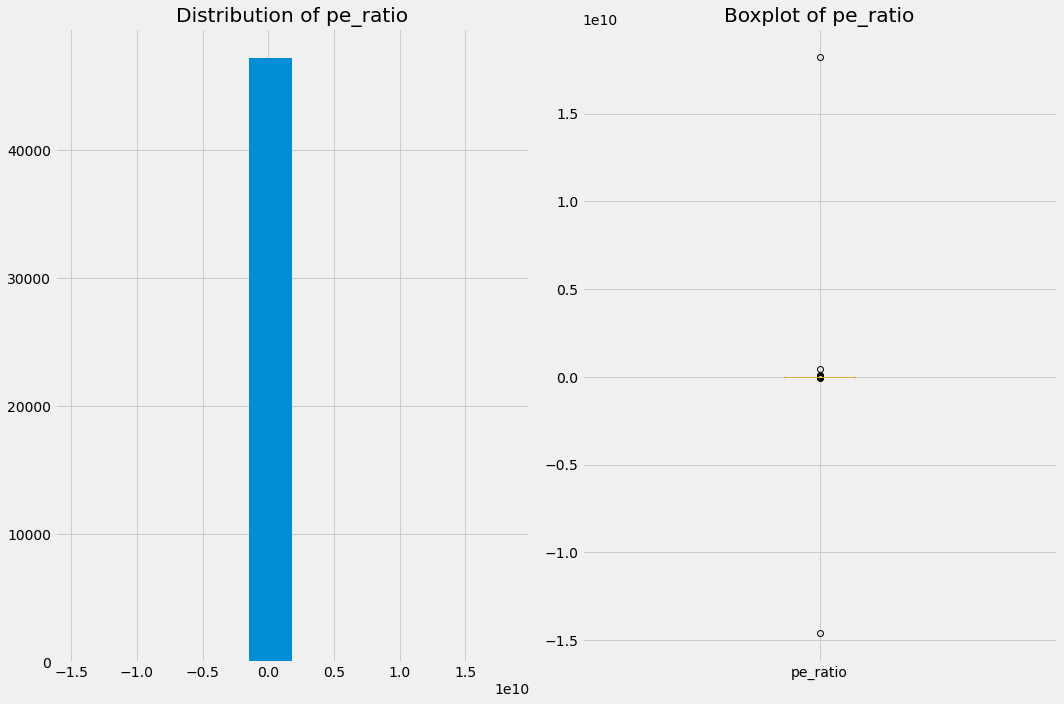



Column Name: ev_to_operating_cashflow
Number of unique values: 31417
There are 15756 duplicates
There are 0 null values
There are 6116 negative values


Descriptive Metrics: 
 count                47,173.0
mean    -1,819,784.6965878434
std       315,568,945.5884349
min       -65,289,224,937.391
25%                     5.331
50%        11.149000000000001
75%                    20.671
max            76,768,461.098
Name: ev_to_operating_cashflow, dtype: float64


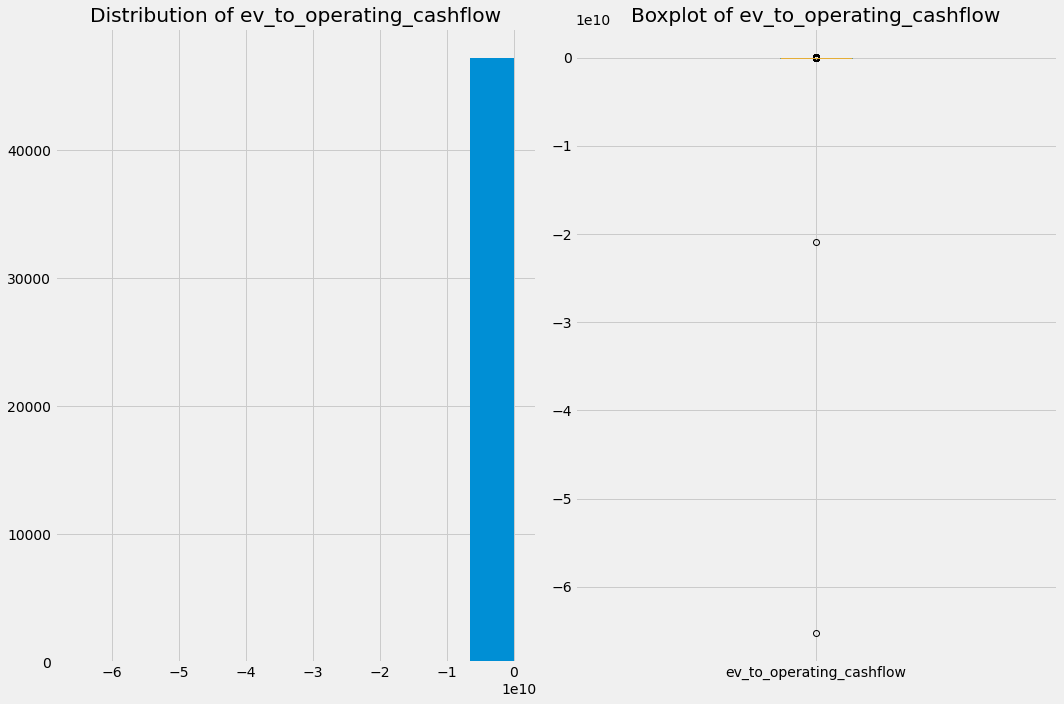



Column Name: enterprise_value_over_EBITDA
Number of unique values: 27969
There are 19204 duplicates
There are 0 null values
There are 5674 negative values


Descriptive Metrics: 
 count               47,173.0
mean    2,657,775.0617892547
std      657,196,531.6825166
min      -16,652,682,010.439
25%                     4.77
50%                    8.791
75%       15.357000000000001
max       141,763,679,909.14
Name: enterprise_value_over_EBITDA, dtype: float64


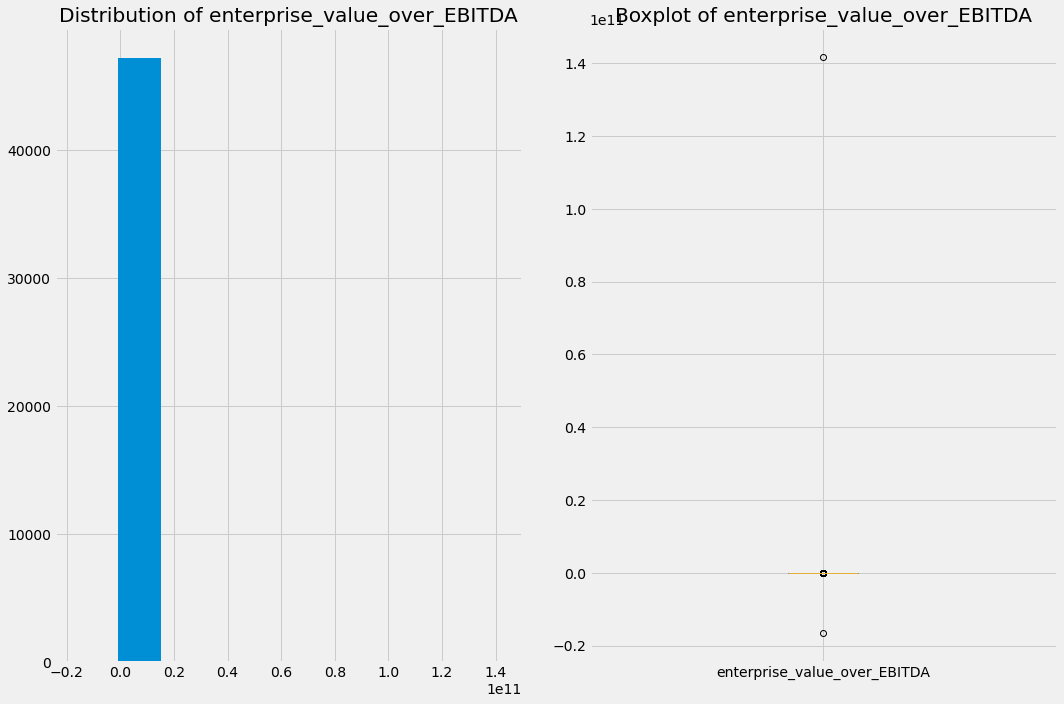



Column Name: ev_to_free_cashflow
Number of unique values: 38965
There are 8208 duplicates
There are 0 null values
There are 15380 negative values


Descriptive Metrics: 
 count               47,173.0
mean    -1,669,181.116258231
std     288,388,448.79745424
min      -59,597,041,608.012
25%                   -7.145
50%                    12.55
75%                   29.309
max           76,455,157.824
Name: ev_to_free_cashflow, dtype: float64


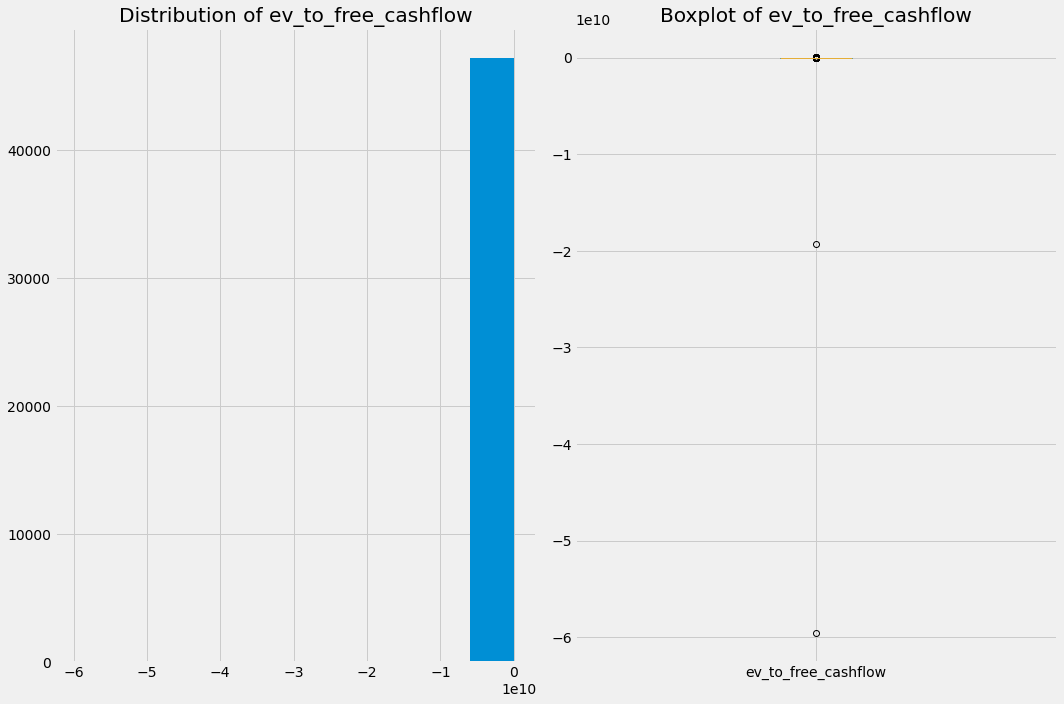



Column Name: price_to_sales_ratio
Number of unique values: 12814
There are 34359 duplicates
There are 0 null values
There are 41 negative values


Descriptive Metrics: 
 count                47,173.0
mean      409,686.60470474284
std       61,574,456.46524066
min                -3,445.136
25%                     0.605
50%                     1.446
75%                     3.804
max     10,027,869,719.786999
Name: price_to_sales_ratio, dtype: float64


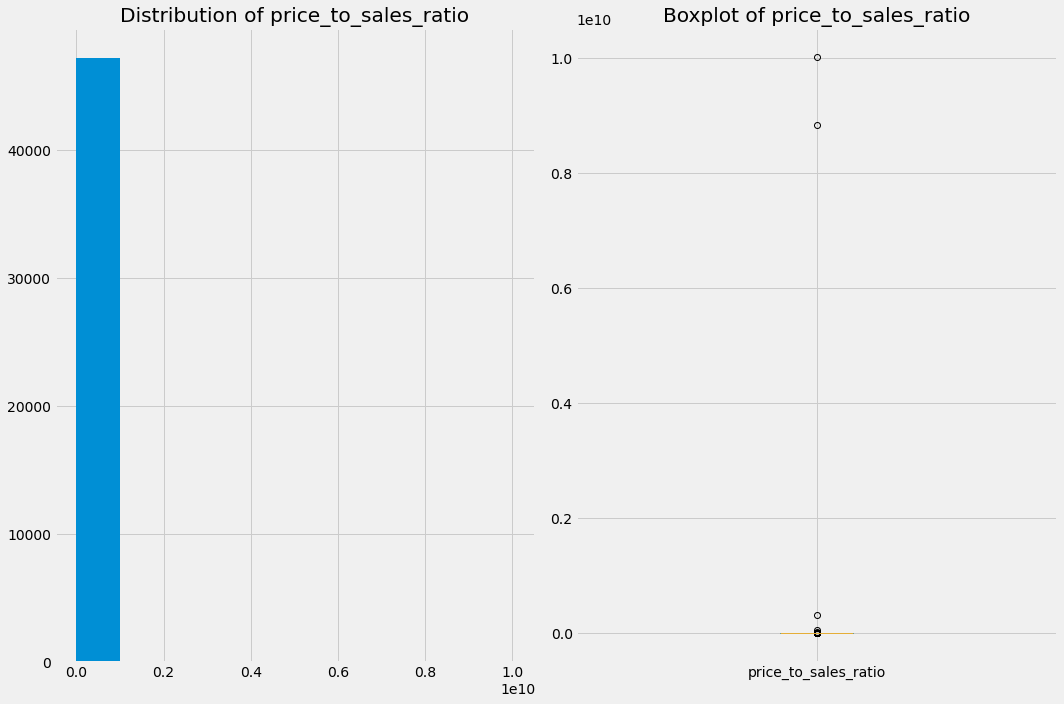



Column Name: revenue_per_share
Number of unique values: 27665
There are 19508 duplicates
There are 0 null values
There are 36 negative values


Descriptive Metrics: 
 count              47,173.0
mean      491.9352726135728
std      32,155.66552630915
min                  -3.717
25%      3.2060000000000004
50%      11.229000000000001
75%                  30.763
max     6,011,429.978999999
Name: revenue_per_share, dtype: float64


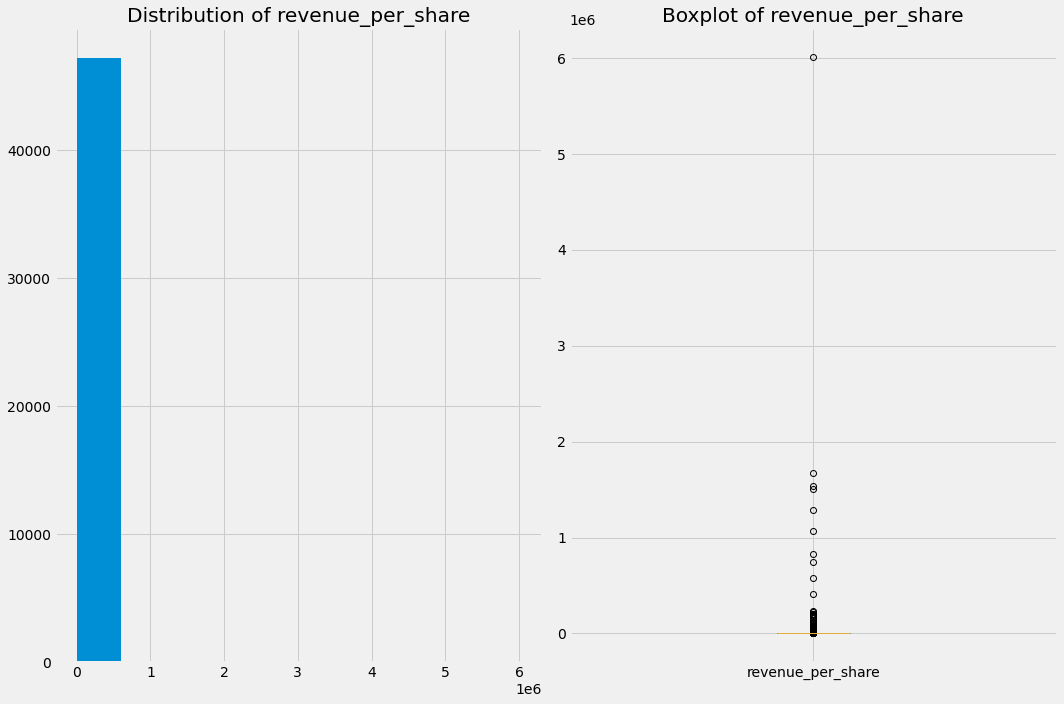



Column Name: market_cap
Number of unique values: 46975
There are 198 duplicates
There are 0 null values
There are 14 negative values


Descriptive Metrics: 
 count                  47,173.0
mean       9,742,905,661,503.35
std     1,610,643,407,761,348.0
min       -9,445,639,594,476.58
25%               279,567,250.0
50%             1,483,178,090.0
75%             8,886,588,480.0
max           3.30167610524e+17
Name: market_cap, dtype: float64


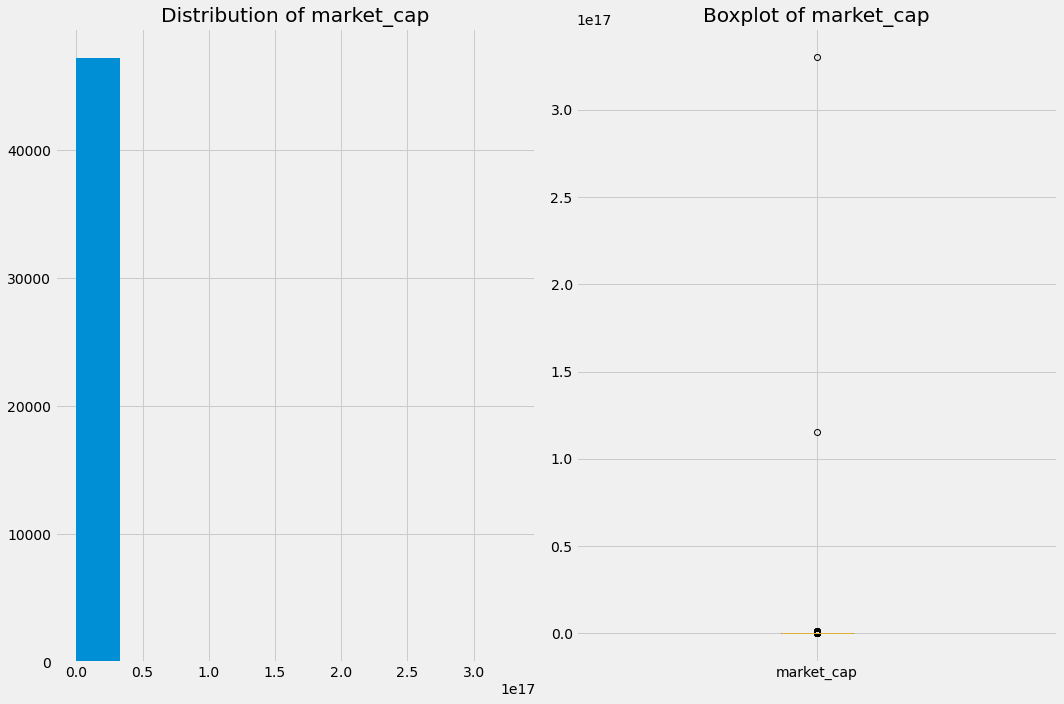

In [457]:
#eval numerical features
for col in num_cols:
  col_eval(df_clean, num_col=col)

> **OBSERVATIONS**
> - All numeric features show outliers on the high end. This distorts the distributions but should not require remediation as each stock will be modeled separately.
> - There are negative values which are either incorrect numbers or do not reflect valuable stocks therefore will rank extremely low in the performance metrics.

> **ACTIONS**
> - Remove negative values for performance metrics

# Feature Engineering 

In [458]:
#create a copy of dataframe for timeseries
df_clean_ts = df_clean.copy()

## Market Cap Groupings

In [459]:
#create market cap grouping
df_clean['market_cap_group'] = None

In [460]:
#fill in market_cap_group based on market_cap value
df_clean.loc[df_clean['market_cap'] > 200_000_000_000, 'market_cap_group'] = 'Mega-Cap'

df_clean.loc[(df_clean['market_cap'] <= 200_000_000_000) &
             (df_clean['market_cap'] > 10_000_000_000), 'market_cap_group'] = 'Large-Cap'

df_clean.loc[(df_clean['market_cap'] <= 10_000_000_000) &
             (df_clean['market_cap'] > 2_000_000_000), 'market_cap_group'] = 'Mid-Cap'

df_clean.loc[(df_clean['market_cap'] <= 2_000_000_000) &
             (df_clean['market_cap'] > 300_000_000), 'market_cap_group'] = 'Small-Cap'

df_clean.loc[df_clean['market_cap'] <= 300_000_000, 'market_cap_group'] = 'Micro-Cap'

In [461]:
#distribution of market cap groups
df_clean['market_cap_group'].value_counts()

Small-Cap    13552
Micro-Cap    12229
Mid-Cap      10267
Large-Cap     9678
Mega-Cap      1447
Name: market_cap_group, dtype: int64

In [462]:
#filter dataframe to only include 2020 performance
df_clean = df_clean.loc[df_clean['date'] == '2020-12-31']

In [463]:
#define performance features
performance_cols = ['pe_ratio','ev_to_operating_cashflow',
                    'enterprise_value_over_EBITDA','ev_to_free_cashflow',
                    'price_to_sales_ratio']

In [464]:
#check dataframe shape before
df_clean.shape

(2273, 16)

In [465]:
#remove negative values for performance metrics
for col in performance_cols:
  df_clean.drop(df_clean.loc[df_clean[col] < 0].index, inplace=True)

In [466]:
#check dataframe shape after
df_clean.shape

(1230, 16)

Comment on how many values were eliminated

In [467]:
#remove the date column
df_clean.drop(columns='date', inplace=True)

In [468]:
#filter dataframe to only micro-cap companies
df_clean = df_clean.loc[df_clean['market_cap_group'] == 'Micro-Cap']

## Value Ranking

In order to find the value ranking for each stock, I will sort each performance feature from best to worst (direction depends on what the feature means) and label the rank from 1 to the end. I will repeat this for each of the 5 performance features and then total up the rankings for each stock to get a total ranking. I will then sort by the total ranking and create a final rank. 

In [469]:
#create value ranking 
for col in performance_cols:
  df_clean[col+'_rank'] = df_clean[col].rank(na_option='bottom', ascending=True).astype(int)

In [471]:
#create value score feature
df_clean['value_score'] = df_clean['pe_ratio_rank'] + \
                            df_clean['ev_to_operating_cashflow_rank'] + \
                            df_clean['enterprise_value_over_EBITDA_rank'] + \
                            df_clean['ev_to_free_cashflow_rank'] + \
                            df_clean['price_to_sales_ratio_rank']

#create value ranking feature
df_clean.sort_values(by='value_score', ascending=True, inplace=True)
df_clean.reset_index(inplace=True, drop=True)
for row in df_clean:
  df_clean['2020_value_ranking'] = df_clean.index + 1

#print the top 20 value companies
df_clean.head(10)

,symbol_id,pe_ratio,ev_to_operating_cashflow,enterprise_value_over_EBITDA,ev_to_free_cashflow,price_to_sales_ratio,revenue_per_share,market_cap,company_name,industry,exchange,sector,country,symbol,market_cap_group,pe_ratio_rank,ev_to_operating_cashflow_rank,enterprise_value_over_EBITDA_rank,ev_to_free_cashflow_rank,price_to_sales_ratio_rank,value_score,2020_value_ranking
0,19264,0.027000000000000003,0.626,0.541,0.7,0.011000000000000001,"15,701.412","152,600,491.842",Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN,Micro-Cap,1,2,2,2,1,8,1
1,10161,5.386,0.43,0.996,0.493,0.124,81.57600000000001,"216,230,900.0",Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS,Micro-Cap,16,1,3,1,4,25,2
2,6760,1.258,1.6130000000000002,2.1830000000000003,1.675,0.011000000000000001,3.576,"4,397,784.28",ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO,Micro-Cap,2,9,11,8,1,31,3
3,17272,3.345,1.864,1.3840000000000001,2.278,0.13,10.92,"29,976,200.0",SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP,Micro-Cap,8,10,6,12,6,42,4
4,7134,3.637,1.871,2.175,1.905,0.161,6.01,"41,852,460.02",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO,Micro-Cap,9,11,10,10,9,49,5
5,343,8.863999999999999,1.101,1.1420000000000001,1.111,0.359,0.373,"178,636,874.0",Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK,Micro-Cap,29,4,5,4,23,65,6
6,9074,2.225,1.104,1.476,1.12,0.6809999999999999,0.235,"2,386,136.16","FullNet Communications, Inc.",Telecom Services,Other OTC,Communication Services,US,FULO,Micro-Cap,5,5,8,5,46,69,7
7,14746,4.457,2.572,2.414,3.2310000000000003,0.154,58.224,"41,074,508.16",Orapi SA,Specialty Chemicals,Paris,Basic Materials,FR,ORAP.PA,Micro-Cap,13,18,12,22,7,72,8
8,13554,6.206,2.773,2.58,3.2910000000000004,0.257,72.167,"38,854,960.0",Mannatech Inc,Household & Personal Products,Nasdaq Global Select,Consumer Defensive,US,MTEX,Micro-Cap,19,23,17,23,16,98,9
9,18302,6.961,2.7569999999999997,3.205,2.963,0.255,7.256,"52,167,176.9",Supremex Inc,Packaging & Containers,Toronto,Consumer Cyclical,CA,SXP.TO,Micro-Cap,23,21,22,19,15,100,10


In [472]:
#check how many symbol_ids have the same value_score
df_clean['value_score'].duplicated().sum()

11

In [473]:
#drop ranking rows
df_clean.drop(columns=['pe_ratio_rank','ev_to_operating_cashflow_rank',
                       'enterprise_value_over_EBITDA_rank', 'ev_to_free_cashflow_rank',
                       'price_to_sales_ratio_rank', 'value_score'], inplace=True)

In [474]:
#round values in dataframe
df_clean = df_clean.round(2)

In [475]:
df_clean

,symbol_id,pe_ratio,ev_to_operating_cashflow,enterprise_value_over_EBITDA,ev_to_free_cashflow,price_to_sales_ratio,revenue_per_share,market_cap,company_name,industry,exchange,sector,country,symbol,market_cap_group,2020_value_ranking
0,19264,0.03,0.63,0.54,0.7,0.01,"15,701.41","152,600,491.84",Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN,Micro-Cap,1
1,10161,5.39,0.43,1.0,0.49,0.12,81.58,"216,230,900.0",Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS,Micro-Cap,2
2,6760,1.26,1.61,2.18,1.68,0.01,3.58,"4,397,784.28",ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO,Micro-Cap,3
3,17272,3.34,1.86,1.38,2.28,0.13,10.92,"29,976,200.0",SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP,Micro-Cap,4
4,7134,3.64,1.87,2.17,1.9,0.16,6.01,"41,852,460.02",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO,Micro-Cap,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,6560,58.18,36.85,60.57,442.12,1.86,7.21,"61,790,887.1",Canterbury Park Holding Corp,Gambling,Nasdaq Global Market,Consumer Cyclical,US,CPHC,Micro-Cap,110
110,20212,60.96,33.07,30.13,40.79,4.2,3.28,"84,428,400.0","Where Food Comes From, Inc.",Software,Other OTC,Technology,US,WFCF,Micro-Cap,111
111,17611,62.31,29.5,32.83,35.42,5.06,1.26,"259,538,880.0",Smith Micro Software Inc,Software Application,Nasdaq Capital Market,Technology,US,SMSI,Micro-Cap,112
112,9192,"5,702.68",19.24,"10,615.42",30.08,807.19,0.0,"16,893,469.22","Global Healthcare REIT, Inc.",REIT—Healthcare Facilities,Other OTC,Real Estate,US,GBCS,Micro-Cap,113


# DATA EXPLORATION

I will explore the list of Micro-cap companies as a whole but also compare that to the top 25 Micro-cap companies.

In [476]:
#create a copy for exploration
df_explore = df_clean.copy()

## Distribution of Industries

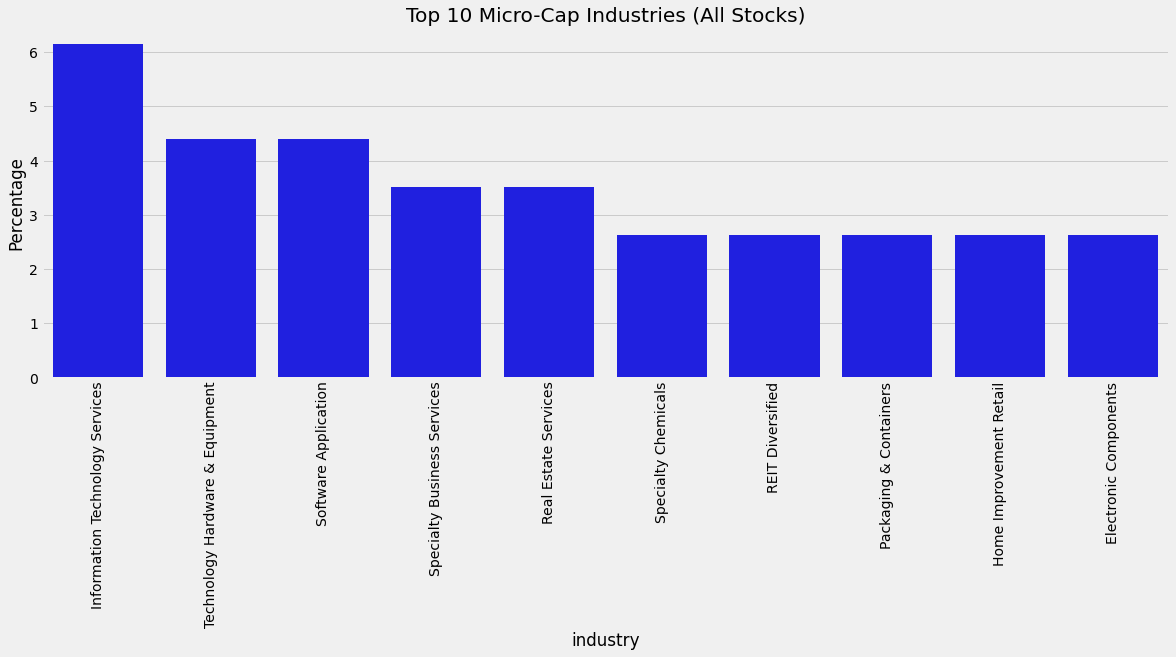

In [477]:
#create industry percentage dataframe
df_explore_industries = round(df_explore.groupby('industry')['symbol_id'].count().sort_values(ascending=False)/len(df_explore)*100,2)
df_explore_industries = pd.DataFrame(data=df_explore_industries).rename(columns={'symbol_id':'Percentage'}).reset_index()
#plot top 10 industries (all stocks)
ax = sns.barplot(data=df_explore_industries, x='industry',y='Percentage', order=df_explore_industries['industry'][:10], color='b')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top 10 Micro-Cap Industries (All Stocks)');

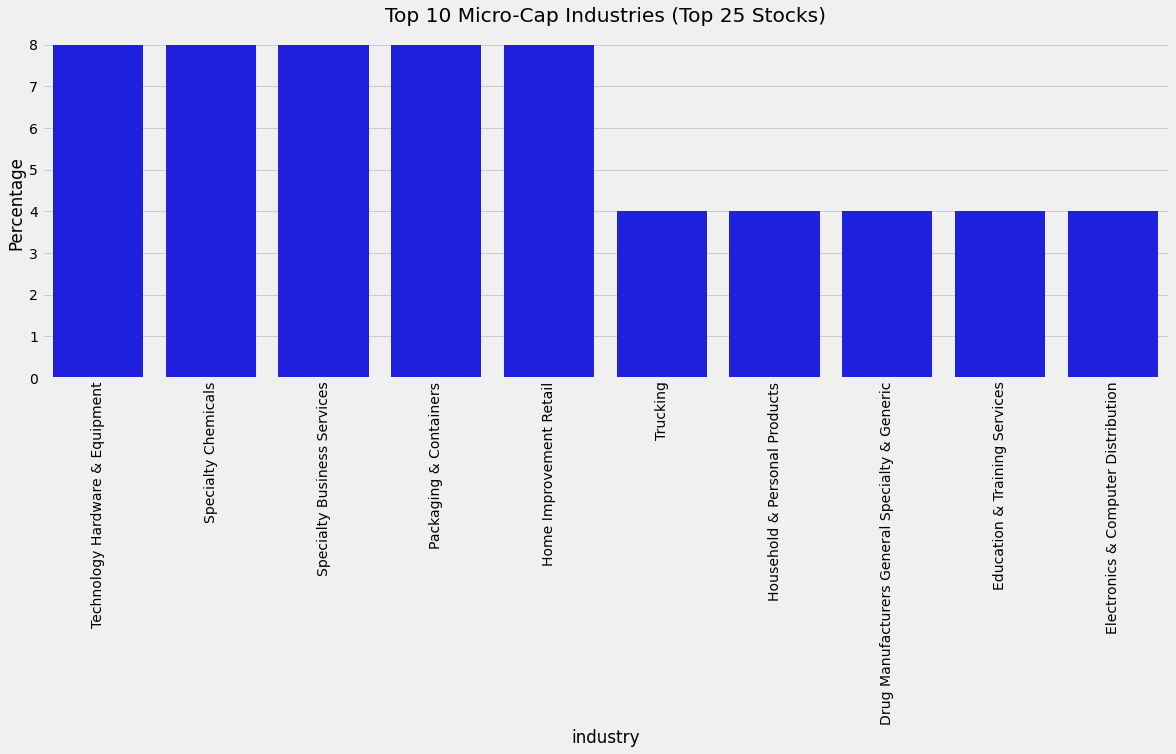

In [478]:
#create industry percentage dataframe (top 25 value stocks)
df_explore_industries_top25 = round(df_explore[:25].groupby('industry')['symbol_id'].count().sort_values(ascending=False)/
                                     len(df_explore[:25])*100,2)
df_explore_industries_top25 = pd.DataFrame(data=df_explore_industries_top25).rename(columns={'symbol_id':'Percentage'}).reset_index()
#plot top 10 industries (top 25 value stocks)
ax = sns.barplot(data=df_explore_industries_top25, x='industry',y='Percentage', order=df_explore_industries_top25['industry'][:10], color='b')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top 10 Micro-Cap Industries (Top 25 Stocks)');

> **OBSERVATIONS**
> - Both the Packaging & Containers and Home Improvement Retail industries took the biggest jump from all micro-cap to the top 25.

## Distribution of Sectors

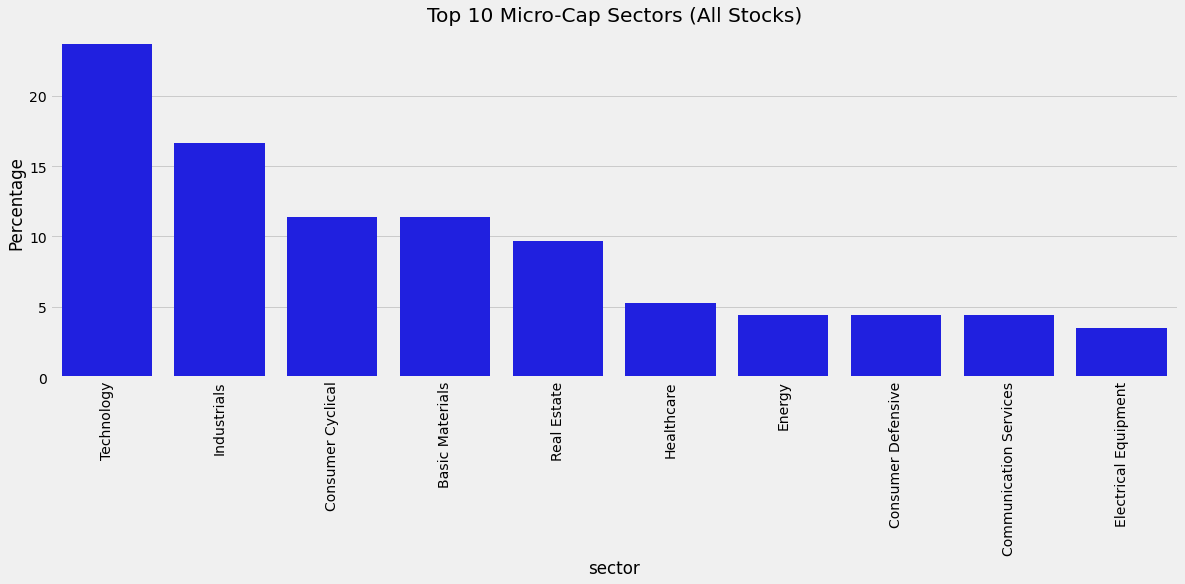

In [479]:
#create sector percentage dataframe
df_explore_sectors = round(df_explore.groupby('sector')['symbol_id'].count().sort_values(ascending=False)/len(df_explore)*100,2)
df_explore_sectors = pd.DataFrame(data=df_explore_sectors).rename(columns={'symbol_id':'Percentage'}).reset_index()
#top 10 sectors (all stocks)
ax = sns.barplot(data=df_explore_sectors, x='sector',y='Percentage', order=df_explore_sectors['sector'][:10], color='b')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top 10 Micro-Cap Sectors (All Stocks)');

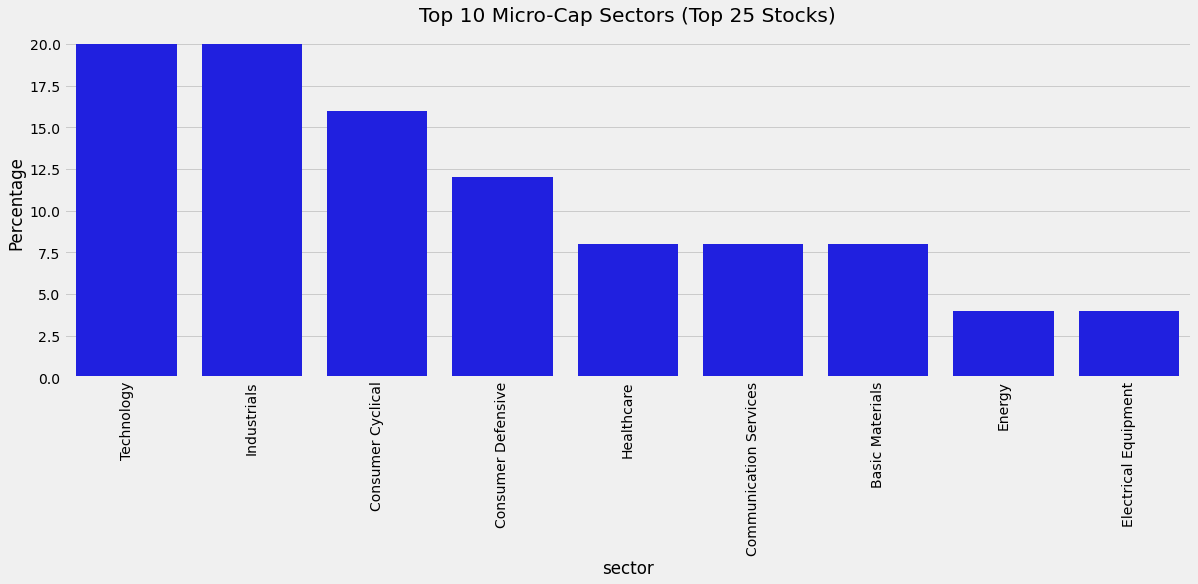

In [480]:
#create sector percentage dataframe (top 25 value stocks)
df_explore_sector_top25 = round(df_explore[:25].groupby('sector')['symbol_id'].count().sort_values(ascending=False)/
                                     len(df_explore[:25])*100,2)
df_explore_sector_top25 = pd.DataFrame(data=df_explore_sector_top25).rename(columns={'symbol_id':'Percentage'}).reset_index()
#top 10 sectors (top 25 value stocks)
ax = sns.barplot(data=df_explore_sector_top25, x='sector',y='Percentage', order=df_explore_sector_top25['sector'][:10], color='b')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top 10 Micro-Cap Sectors (Top 25 Stocks)');

> ** OBSERVATIONS**
> - The Consumer Defensive sector had the largest jump from all micro-caps to the top 25 while Basic Materials slipped the most.

## Distribution of Country

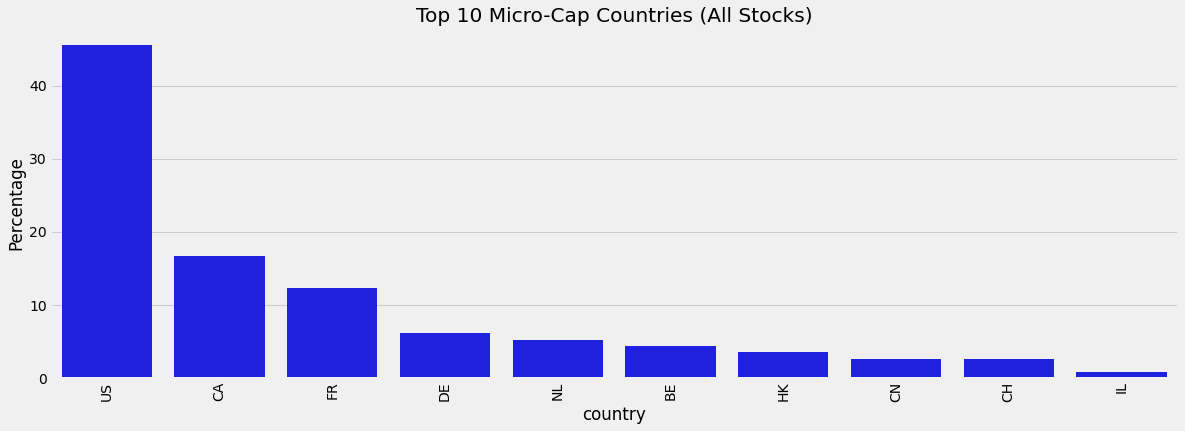

In [481]:
#create country percentage dataframe
df_explore_countries = round(df_explore.groupby('country')['symbol_id'].count().sort_values(ascending=False)/len(df_explore)*100,2)
df_explore_countries = pd.DataFrame(data=df_explore_countries).rename(columns={'symbol_id':'Percentage'}).reset_index()
#top 10 sectors (all stocks)
ax = sns.barplot(data=df_explore_countries, x='country',y='Percentage', order=df_explore_countries['country'][:10], color='b')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top 10 Micro-Cap Countries (All Stocks)');

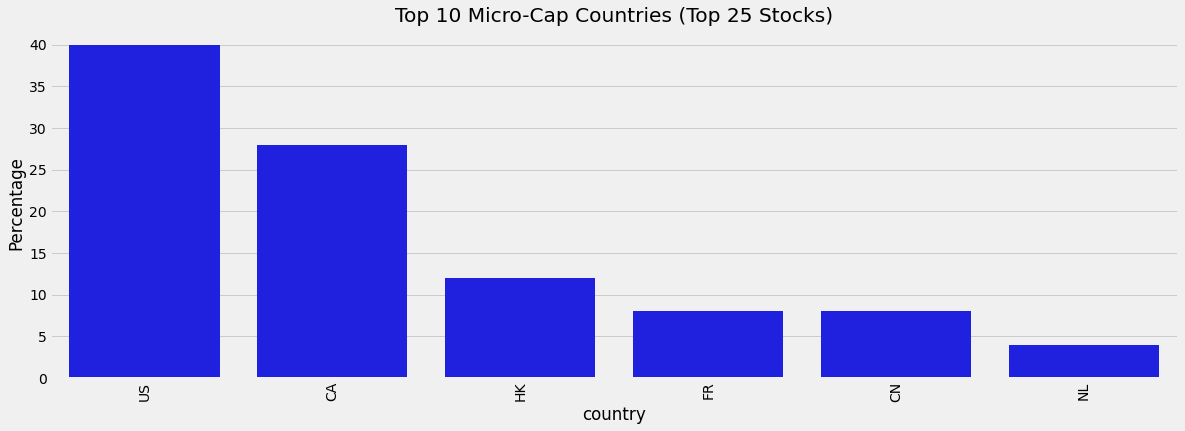

In [482]:
#create country percentage dataframe (top 25 value stocks)
df_explore_countries_top25 = round(df_explore[:25].groupby('country')['symbol_id'].count().sort_values(ascending=False)/
                                     len(df_explore[:25])*100,2)
df_explore_countries_top25 = pd.DataFrame(data=df_explore_countries_top25).rename(columns={'symbol_id':'Percentage'}).reset_index()
#top 10 sectors (top 25 value stocks)
ax = sns.barplot(data=df_explore_countries_top25, x='country',y='Percentage', order=df_explore_countries_top25['country'][:10], color='b')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_title('Top 10 Micro-Cap Countries (Top 25 Stocks)');

> **OBSERVATIONS**
> - The top country is the United States for both total micro-cap stocks as well as the top 25 value micro-cap stocks. Hong Kong had the largest jump.

# MODELING

I will now create a dataframe with only the top 10 value stocks and recombine their historical data to begin modeling for forecasting their growth based on `revenue_per_share`.

In [483]:
#create a ts copy
df_model_ts = df_clean_ts.copy()

In [484]:
#create a list of the top 10 stocks for modeling
modeling_symbol_ids = df_clean['symbol_id'][:10].tolist()
modeling_symbol_ids

['19264',
 '10161',
 '6760',
 '17272',
 '7134',
 '343',
 '9074',
 '14746',
 '13554',
 '18302']

In [485]:
#filter timeseries dataframe to include only the top 10 value symbol_ids
df_model_ts = df_model_ts.loc[df_model_ts['symbol_id'].isin(modeling_symbol_ids)]

In [486]:
#set index to date column
df_model_ts.set_index('date', inplace=True)

In [487]:
#remove all columns except for ones needed for modeling
df_model_ts.drop(columns=['pe_ratio','ev_to_operating_cashflow',
                          'enterprise_value_over_EBITDA', 'ev_to_free_cashflow',
                          'price_to_sales_ratio', 'market_cap'], inplace=True)

In [488]:
#look at head of the datframe
df_model_ts.head()

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2020-12-31,343,0.373,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2019-12-31,343,0.39899999999999997,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2018-12-31,343,0.40399999999999997,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2017-12-31,343,0.488,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2016-12-31,343,0.46399999999999997,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK


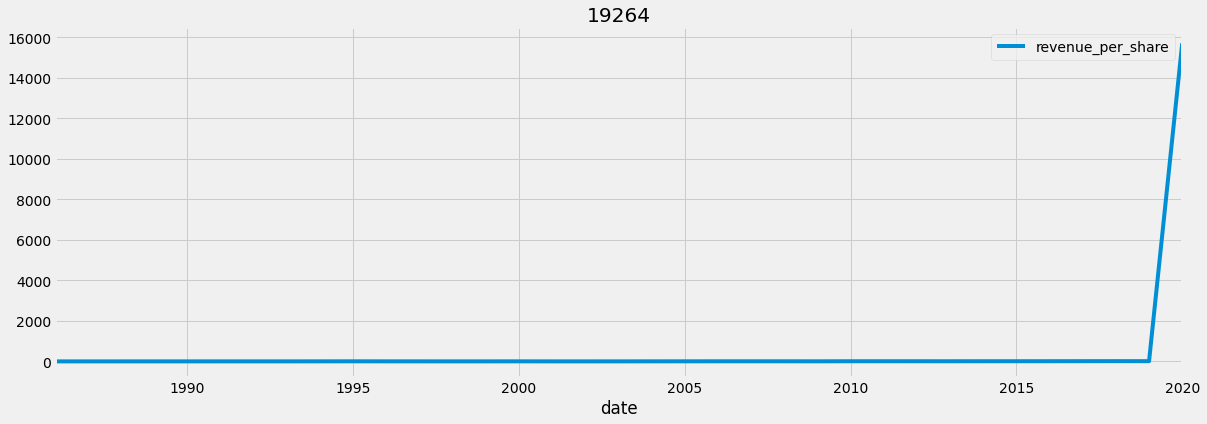

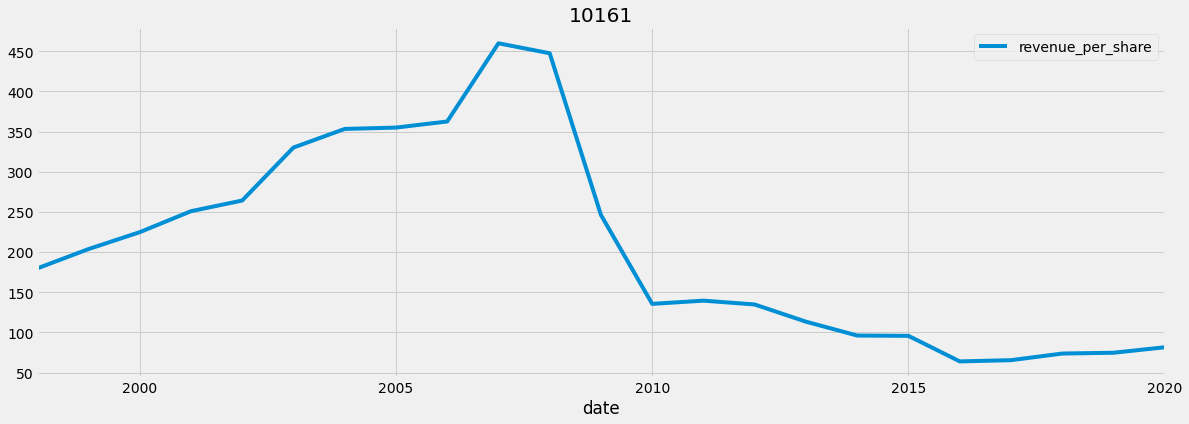

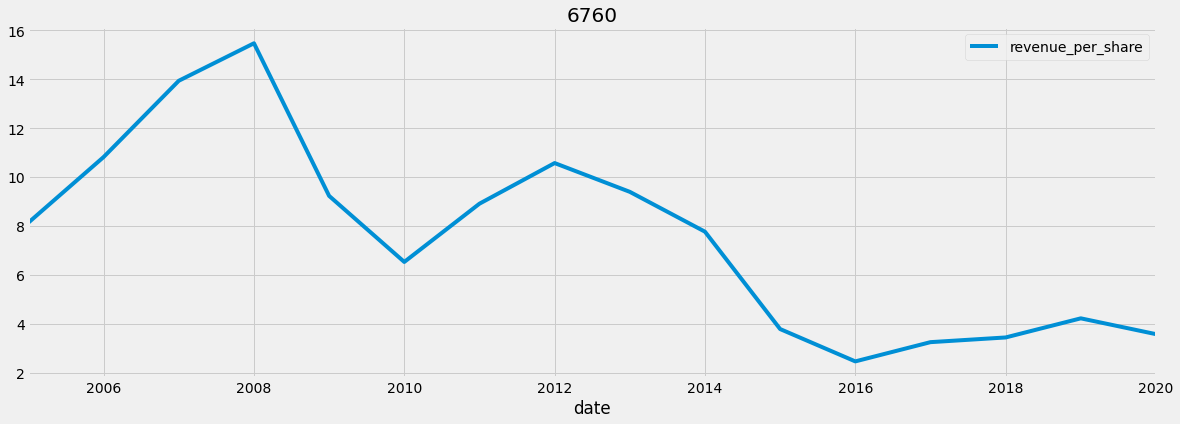

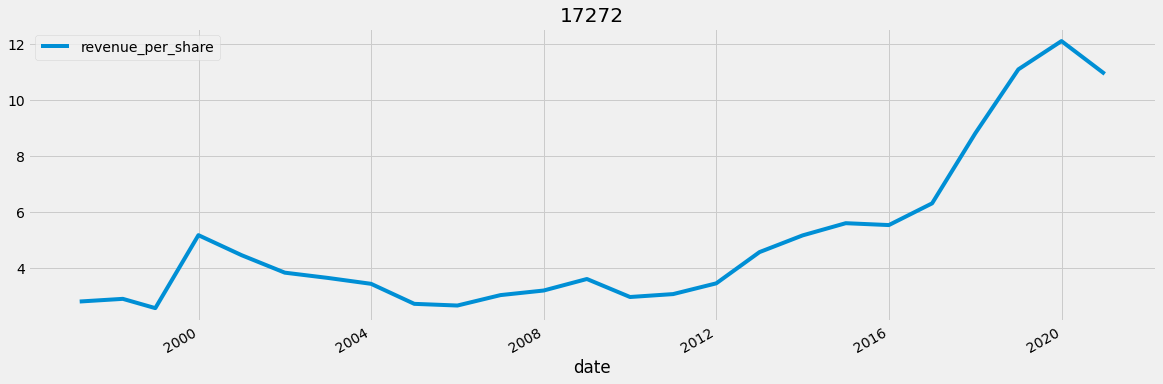

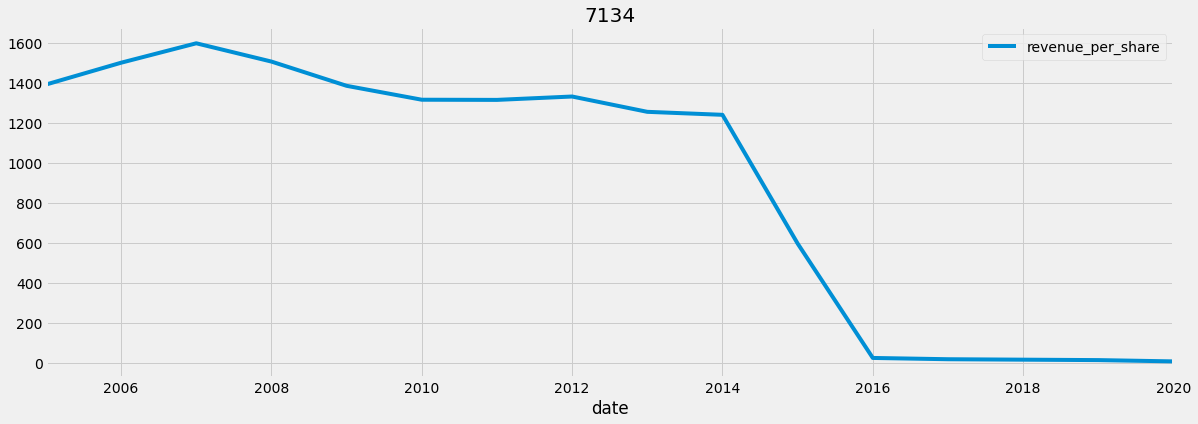

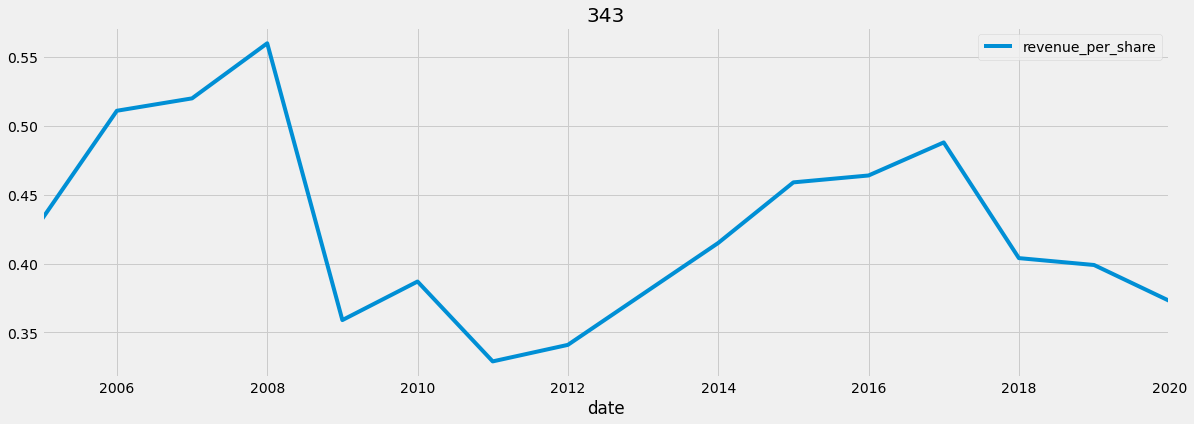

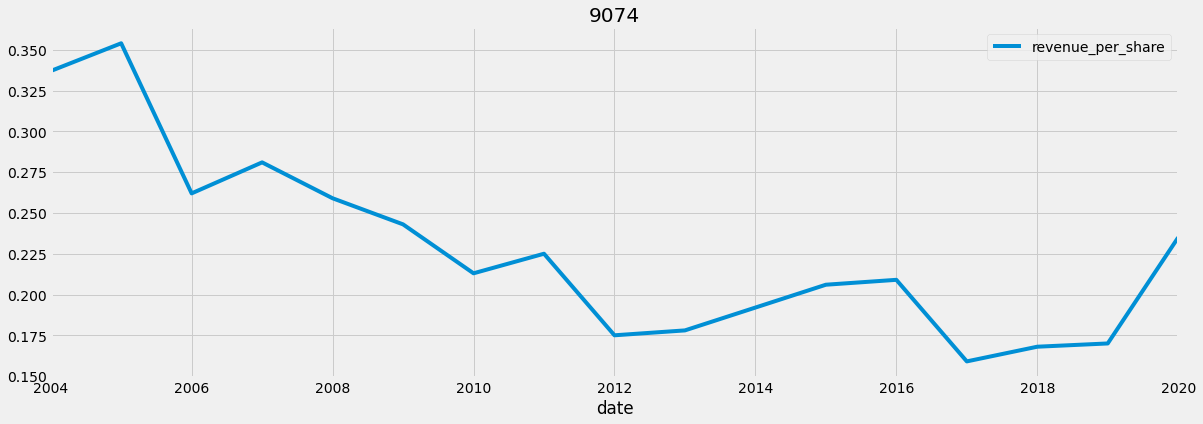

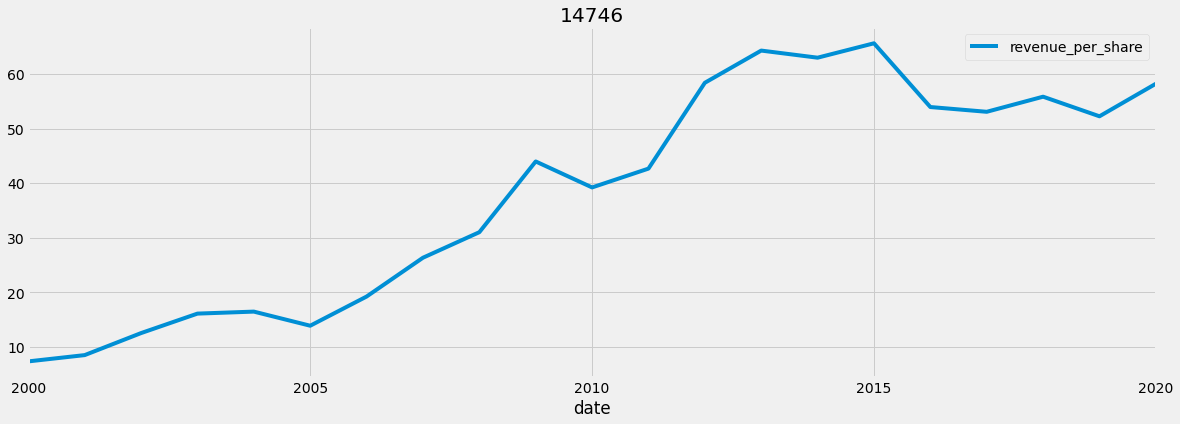

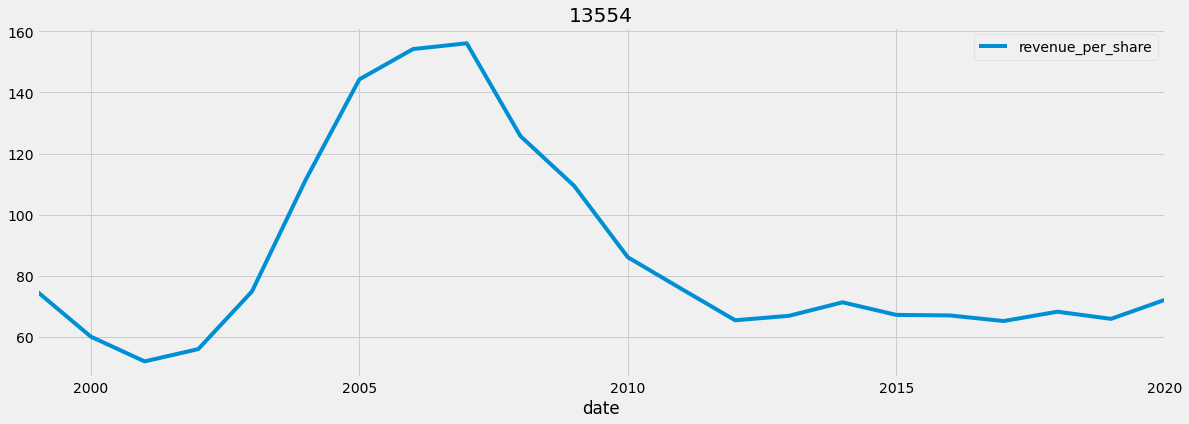

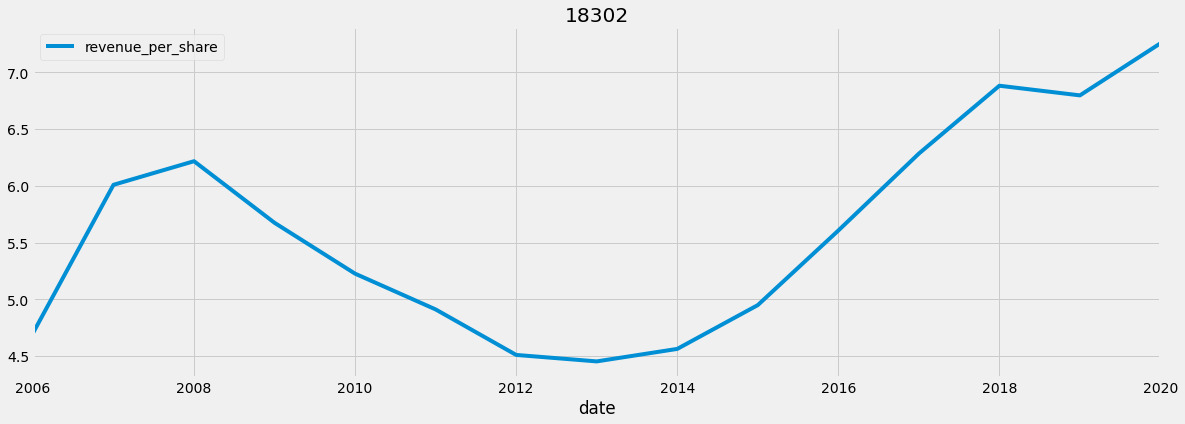

In [489]:
#plot all time series for top 10 value stocks
for symbol in modeling_symbol_ids:
  df_model_ts.loc[df_model_ts['symbol_id'] == symbol].plot()
  plt.title(f'{symbol}')
  

## Model Symbol ID 19264

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1986-12-31,19264,4.093999999999999,Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN
1987-12-31,19264,4.433,Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN
1988-12-31,19264,4.751,Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN
1989-12-31,19264,4.7989999999999995,Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN
1990-12-31,19264,5.0280000000000005,Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN
1991-12-31,19264,5.171,Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN
1992-12-31,19264,5.4510000000000005,Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN
1993-12-31,19264,5.69,Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN
1994-12-31,19264,6.7829999999999995,Texas Instruments Inc,Semiconductors,Nasdaq Global Select,Technology,US,TXN


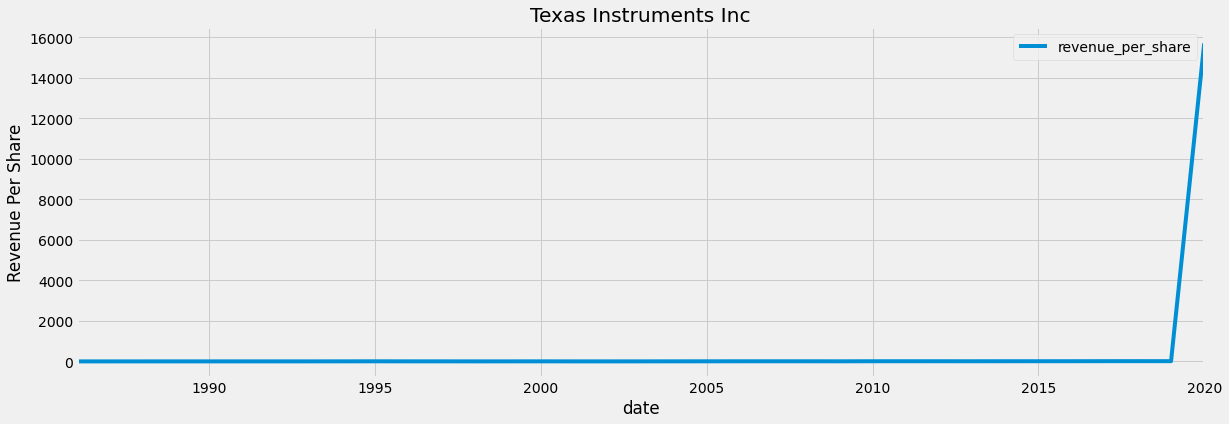

In [490]:
#create dataframe and plot
df_model_ts_19264 = timeseries_creation(df_model_ts, '19264')

> **OBSERVATIONS**
> - The value for revenue per share for 12-31-2020 is an outlier. Looking at previous values, I believe the decimal point is in the wrong spot. 

> **ACTIONS**
> - I will change the value from 15,701.412 to 15.701412.

In [491]:
#change revenue per share
df_model_ts_19264.loc[df_model_ts_19264['revenue_per_share'] == 15701.412,'revenue_per_share'] = 15.701412

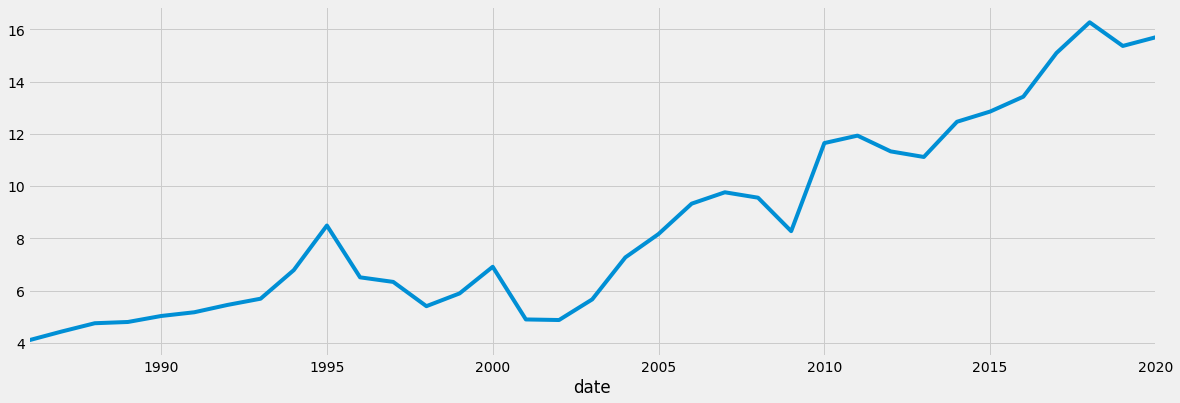

In [492]:
df_model_ts_19264['revenue_per_share'].plot()

### Seasonality & Stationarity

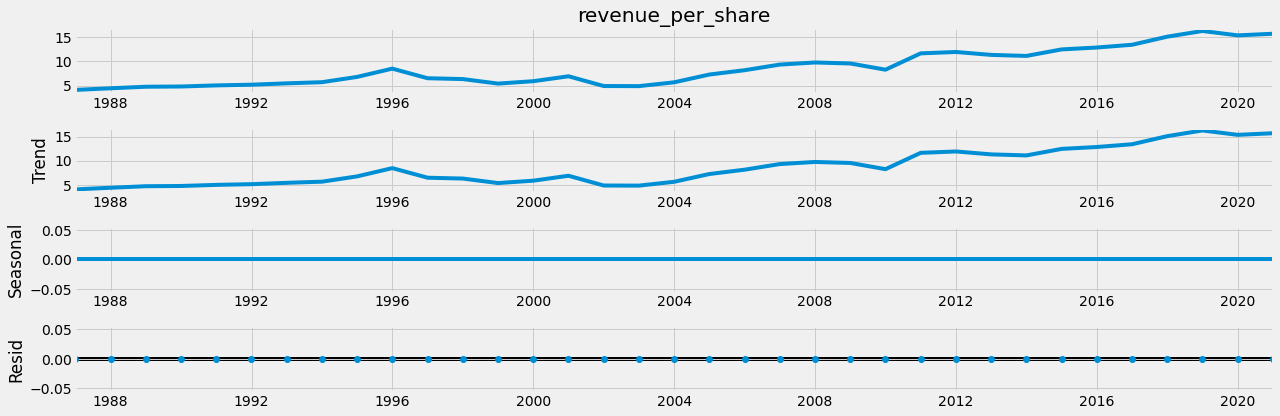

Augmented Dickey-Fuller Test Results
ADF test statistic   -0.13746468353587213
p-value                0.9455766747816438
# lags used                           0.0
# observations                       34.0


The data is not stationary


In [493]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_19264['revenue_per_share'])

> **OBSERVATIONS**
> - The ADFuller test shows the data is not stationary and will require differencing. There is no seasonality.

> **ACTIONS**
> - I will evaluate how differincing will impact the models performance

### Model Creation & Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   32
Model:               SARIMAX(2, 2, 1)   Log Likelihood                 -45.999
Date:                Wed, 30 Jun 2021   AIC                             99.999
Time:                        03:38:29   BIC                            105.603
Sample:                    12-31-1986   HQIC                           101.792
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1080      0.314     -0.344      0.731      -0.723       0.507
ar.L2         -0.1968      0.281     -0.700      0.484      -0.748       0.354
ma.L1         -0.9381      0.266     -3.526      0.000      -1.459      -0.417
sigma2         1.1499      0.430      2.672      0.008       0.306       1.993
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.70   Prob(JB):                         0.80
Heteroskedasticity (H):               1.94   Skew:                            -0.01
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 0.57
The mean of revenue_per_share is 8.59


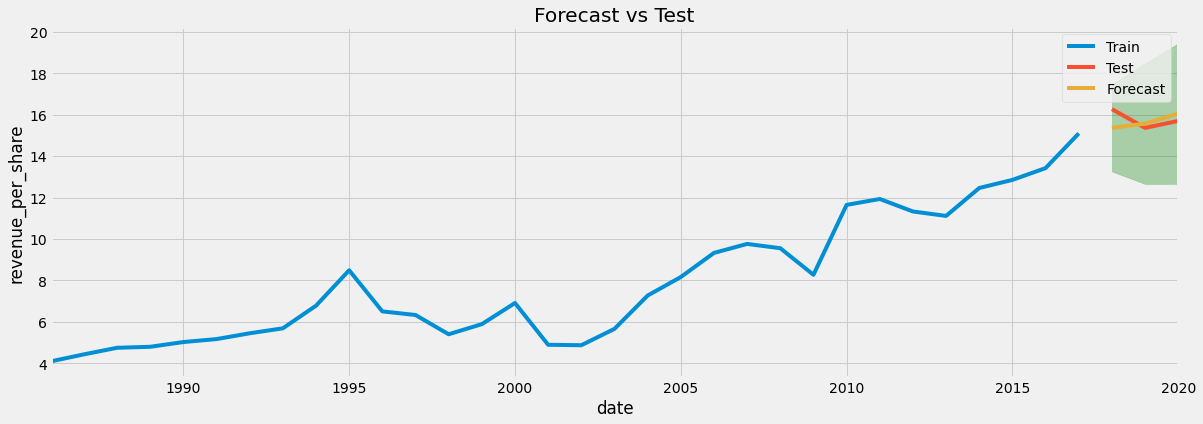

In [494]:
#create and evaluate the auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_19264, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, d=2, auto=True)

> **OBSERVATIONS**
> - The rmse is pretty good considering it is less than 7% of the mean value of the timeseries. I had to force d=2 to get the best results. The best model is an ARIMA (2,2,1)

> **ACTIONS**
> - I will utilize the auto-arima model to forecast into the future

### Model Forecast

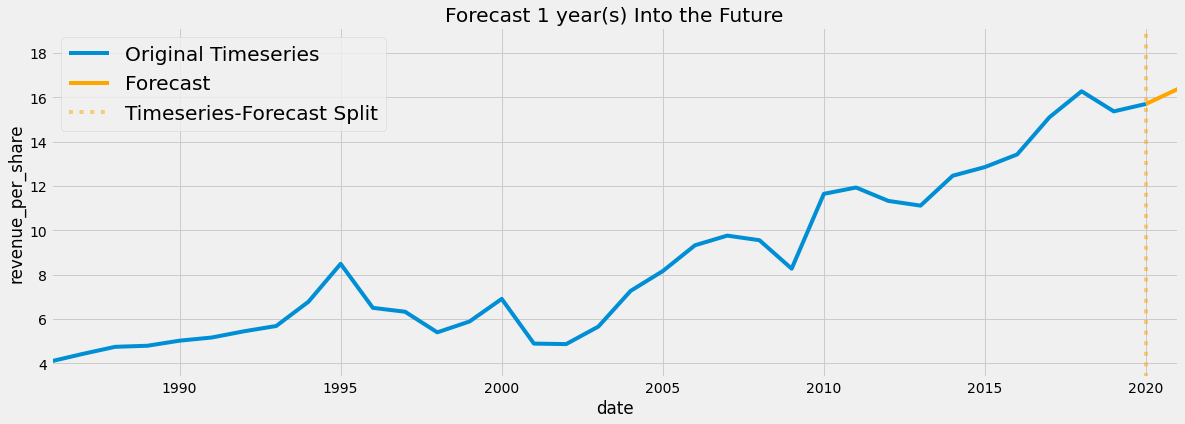



The percent change 1 year(s) into the future is 4.34%


In [495]:
#forecast 1 year into the future and save percent change
percent_change_19264 = forecast(df_model_ts_19264, ts_col='revenue_per_share', 
                               best_model_ts=auto_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - The forecast shows a decrease in revenue per share of 4.34% between 2020 and 2021.

## Model Symbol ID 10161

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1998-12-31,10161,179.717,Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS
1999-12-31,10161,203.787,Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS
2000-12-31,10161,224.81,Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS
2001-12-31,10161,250.929,Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS
2002-12-31,10161,264.224,Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS
2003-12-31,10161,330.171,Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS
2004-12-31,10161,353.351,Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS
2005-12-31,10161,355.017,Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS
2006-12-31,10161,362.616,Heijmans NV,Engineering & Construction,Amsterdam,Industrials,NL,HEIJM.AS


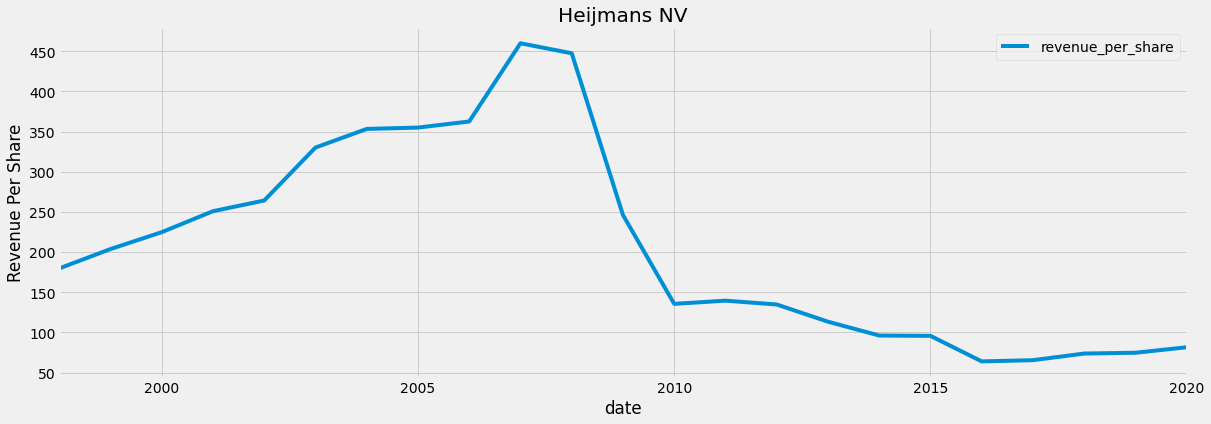

In [496]:
#create dataframe and plot
df_model_ts_10161 = timeseries_creation(df_model_ts, '10161')

### Seasonality & Stationarity

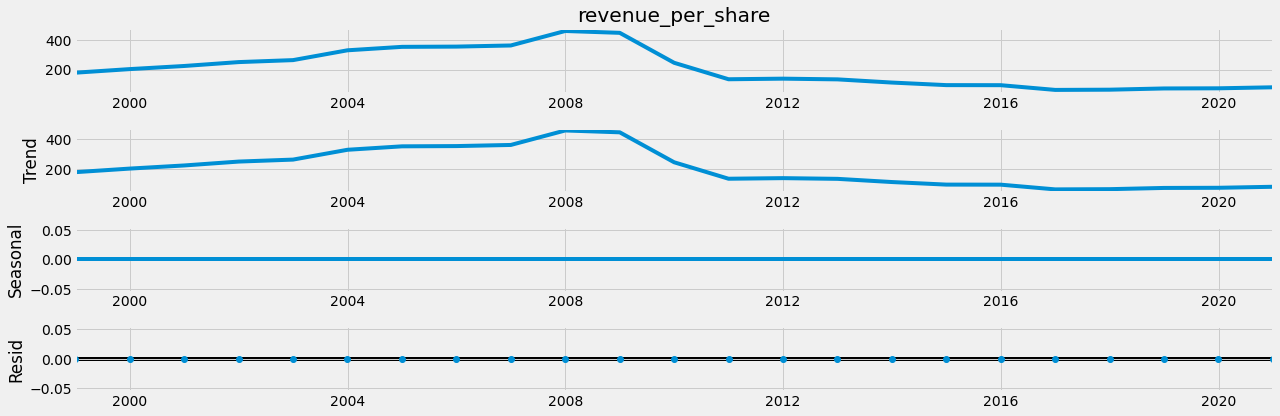

Augmented Dickey-Fuller Test Results
ADF test statistic   -1.8601433439111752
p-value              0.35103682969797034
# lags used                          9.0
# observations                      13.0


The data is not stationary


In [497]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_10161['revenue_per_share'])

> **OBSERVATIONS**
> - There is no seasonality and the data is not stationary so requires differencing

### Model Creation & Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   20
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -101.700
Date:                Wed, 30 Jun 2021   AIC                            205.401
Time:                        03:38:31   BIC                            206.291
Sample:                    12-31-1998   HQIC                           205.524
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4732.2498   1226.589      3.858      0.000    2328.180    7136.320
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 3.11
Prob(Q):                              1.00   Prob(JB):                         0.21
Heteroskedasticity (H):               0.52   Skew:                            -0.80
Prob(H) (two-sided):                  0.45   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 8.5
The mean of revenue_per_share is 206.66


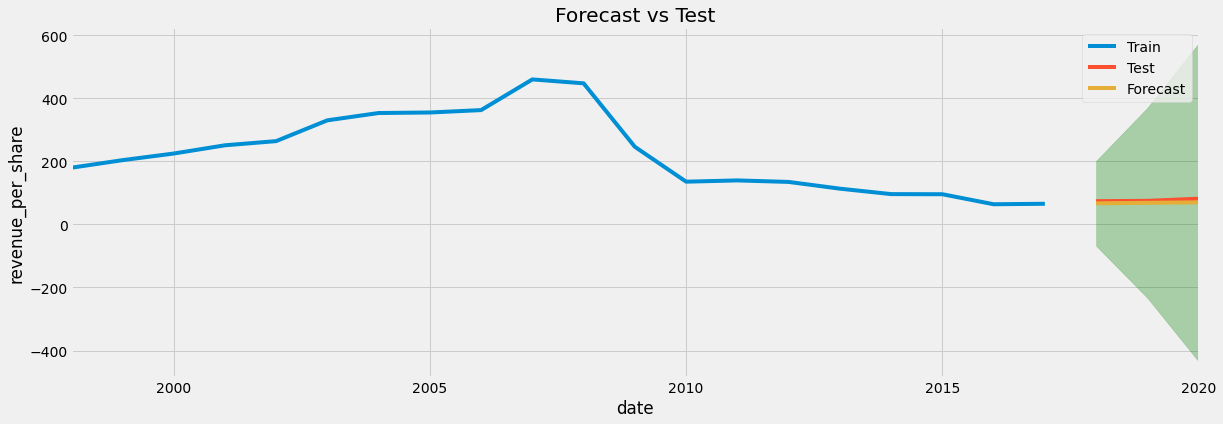

In [498]:
#create and evaluate the auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_10161, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, d=2, auto=True)

> **OBSERVATIONS**
> - I got the best auto-arima model from forcing d=2 and a test size of 3 years. The best model was ARIMA (0,2,0)

### Model Forecast

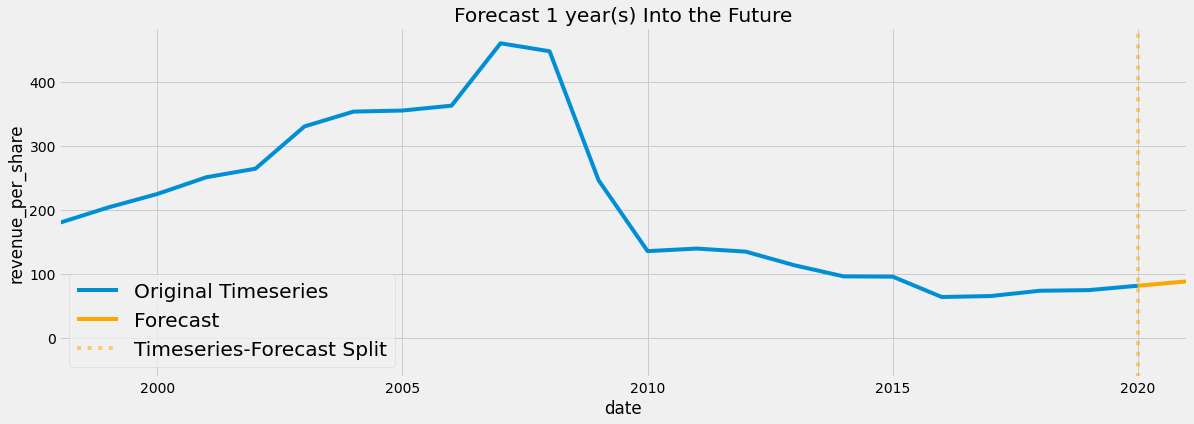



The percent change 1 year(s) into the future is 8.37%


In [499]:
#forecast 1 year into the future and save percent change
percent_change_10161 = forecast(df_model_ts_10161, ts_col='revenue_per_share', 
                               best_model_ts=auto_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - The forecast shows a decrease in revenue per share of 8.39% between 2020 and 2021.

## Model Symbol ID 6760

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2005-12-31,6760,8.139,ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO
2006-12-31,6760,10.821,ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO
2007-12-31,6760,13.94,ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO
2008-12-31,6760,15.472999999999999,ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO
2009-12-31,6760,9.231,ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO
2010-12-31,6760,6.53,ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO
2011-12-31,6760,8.912,ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO
2012-12-31,6760,10.574000000000002,ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO
2013-12-31,6760,9.397,ClearStream Energy Services Inc,Oil & Gas Equipment & Services,Toronto,Energy,CA,CSM.TO


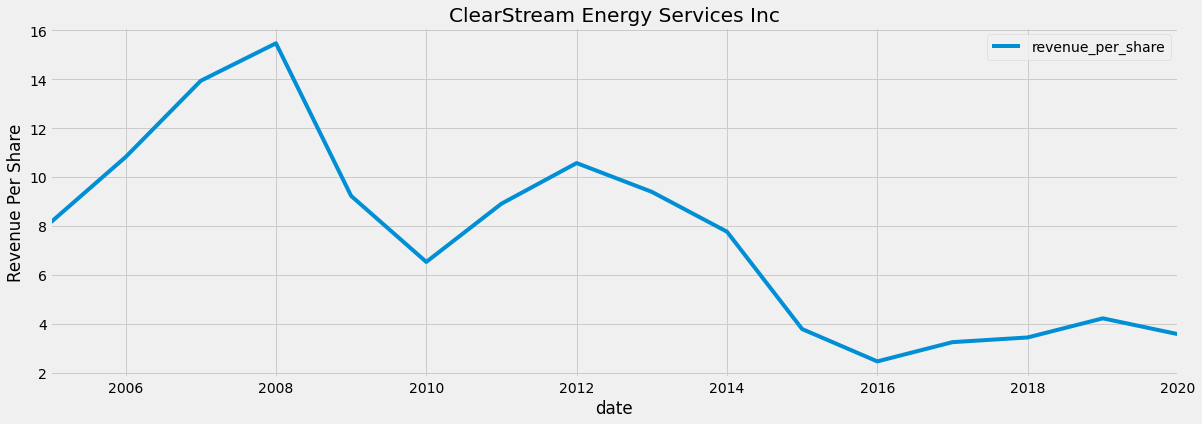

In [500]:
#create dataframe and plot
df_model_ts_6760 = timeseries_creation(df_model_ts, '6760')

### Seasonality & Stationarity

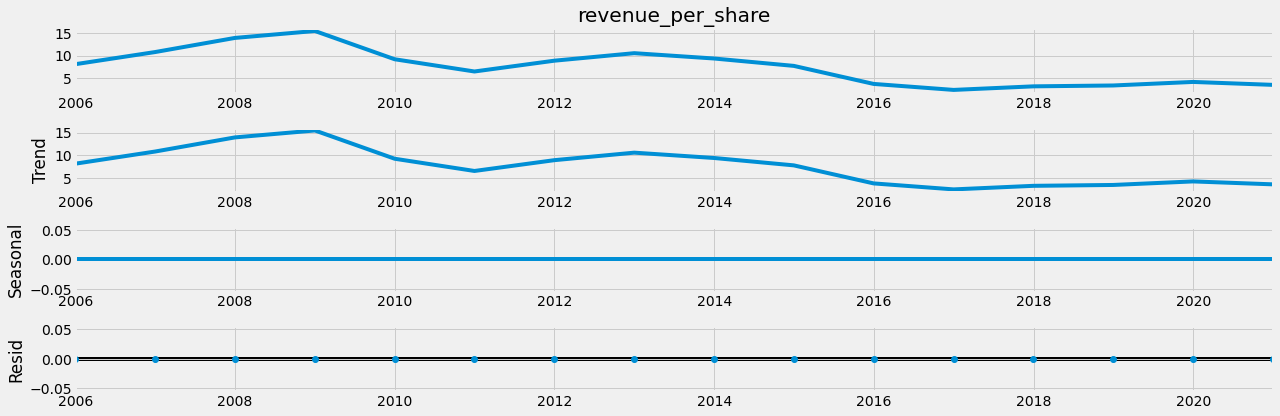

Augmented Dickey-Fuller Test Results
ADF test statistic   -0.8571246406554874
p-value               0.8017639283229212
# lags used                          6.0
# observations                       9.0


The data is not stationary


In [501]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_6760['revenue_per_share'])

> **OBSERVATIONS**
> - The ADFuller test shows the data is not stationary and will require differencing. There is no seasonality.

> **ACTIONS**
> - I will evaluate how differincing will impact the models performance

### Model Creation & Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   13
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -29.079
Date:                Wed, 30 Jun 2021   AIC                             60.158
Time:                        03:38:33   BIC                             60.556
Sample:                    12-31-2005   HQIC                            59.907
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        11.5789      4.758      2.434      0.015       2.254      20.904
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.97   Prob(JB):                         0.75
Heteroskedasticity (H):               0.23   Skew:                            -0.56
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 1.27
The mean of revenue_per_share is 7.59


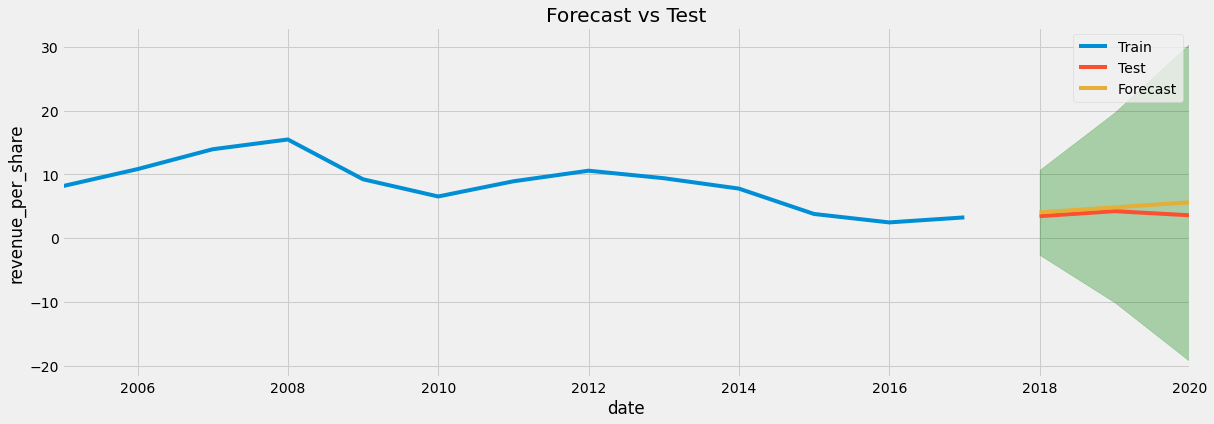

In [502]:
#create and evaluate the auto model
auto_model = create_eval_model(df=df_model_ts_6760, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, d=2, auto=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   13
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -28.961
Date:                Wed, 30 Jun 2021   AIC                             61.922
Time:                        03:38:34   BIC                             62.891
Sample:                    12-31-2005   HQIC                            61.563
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2972      0.535      0.556      0.578      -0.751       1.345
sigma2         7.2515      3.239      2.239      0.025       0.903      13.600
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.57   Prob(JB):                         0.41
Heteroskedasticity (H):               0.27   Skew:                            -0.93
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 0.39
The mean of revenue_per_share is 7.59


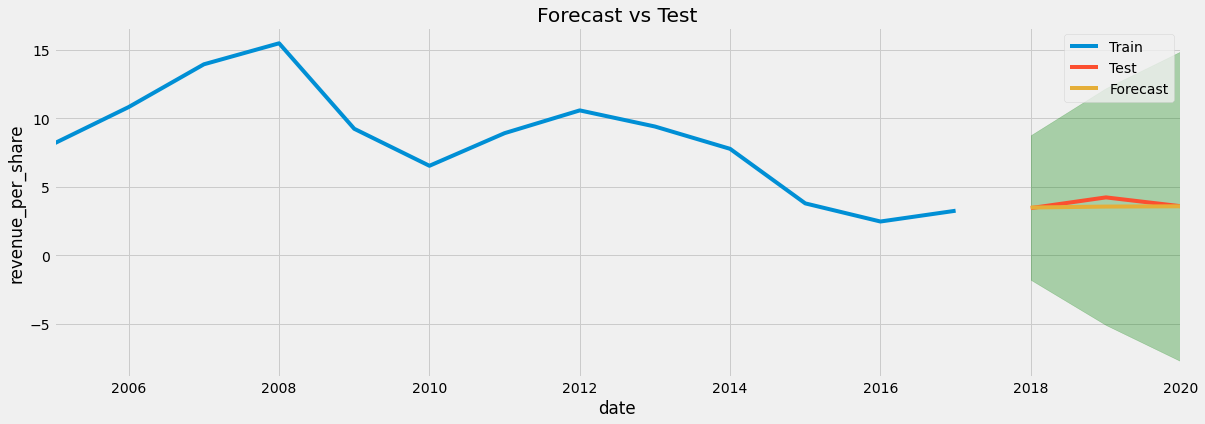

In [503]:
#create and evaluate the auto model
user_model, train, test, user_model_ts = create_eval_model(df=df_model_ts_6760, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, auto=False, order=(1,1,0))

> **OBSERVATIONS**
> - The best fitting model is a user model ARIMA (1,1,0) with a test size of 3 years. 
> - The mse is 0.39 which is really good.

> **ACTIONS**
> - Will continue with the user model for forecasting

### Model Forecast

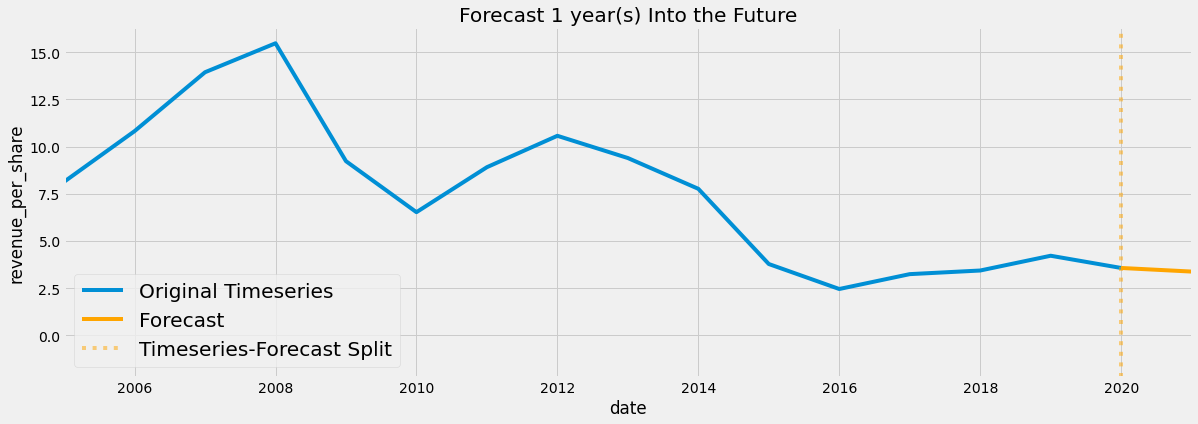



The percent change 1 year(s) into the future is -5.35%


In [504]:
#forecast 1 year into the future and save percent change
percent_change_6760 = forecast(df_model_ts_6760, ts_col='revenue_per_share', 
                               best_model_ts=user_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - The forecast shows a decrease in revenue per share of -5.35% between 2020 and 2021.

## Model Symbol ID 17272

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1997-03-31,17272,2.803,SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP
1998-03-31,17272,2.898,SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP
1998-12-31,17272,2.5669999999999997,SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP
1999-12-31,17272,5.169,SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP
2000-12-31,17272,4.454,SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP
2001-12-31,17272,3.832,SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP
2002-12-31,17272,3.6439999999999997,SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP
2003-12-31,17272,3.4339999999999997,SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP
2004-12-31,17272,2.72,SPAR Group Inc,Specialty Business Services,Nasdaq Capital Market,Industrials,US,SGRP


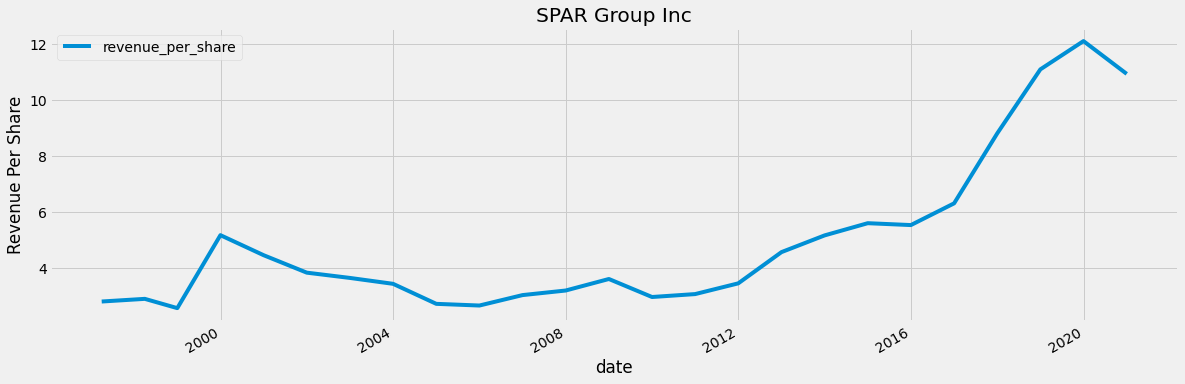

In [505]:
#create dataframe and plot
df_model_ts_17272 = timeseries_creation(df_model_ts, '17272')

In [506]:
#remove the first 2 years which have a different cadence than the others
df_model_ts_17272 = df_model_ts_17272[2:]

### Seasonality & Stationarity

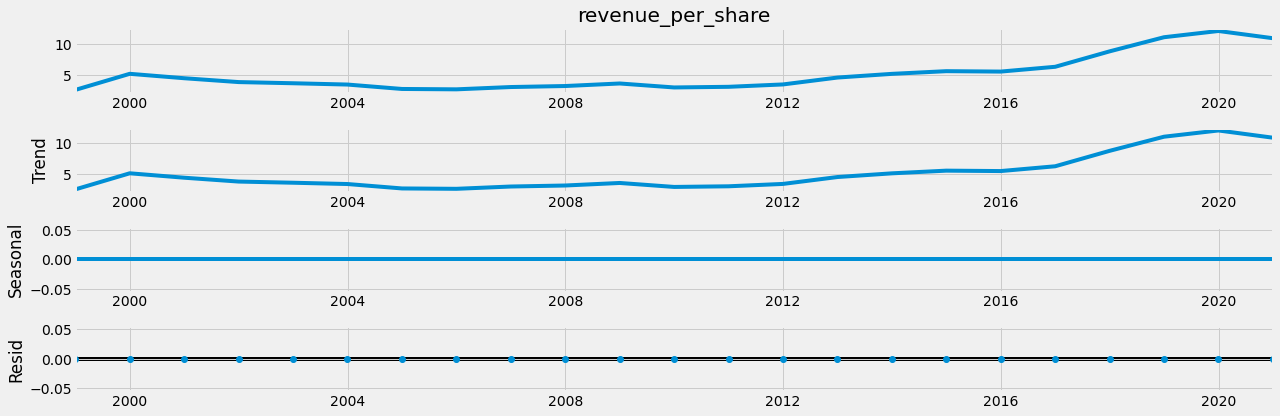

Augmented Dickey-Fuller Test Results
ADF test statistic   0.28050107708919353
p-value               0.9764319870936898
# lags used                          5.0
# observations                      17.0


The data is not stationary


In [507]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_17272['revenue_per_share'])

> **OBSERVATIONS**
> - The data is not stationary and has no seasonality

> **ACTIONS**
> - Evaluate differencing if auto-arima doesn't

### Model Creation & Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   19
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -23.449
Date:                Wed, 30 Jun 2021   AIC                             48.898
Time:                        03:38:36   BIC                             49.732
Sample:                    12-31-1998   HQIC                            48.981
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9239      0.163      5.659      0.000       0.604       1.244
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                28.38
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -2.10
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 2.63
The mean of revenue_per_share is 5.12


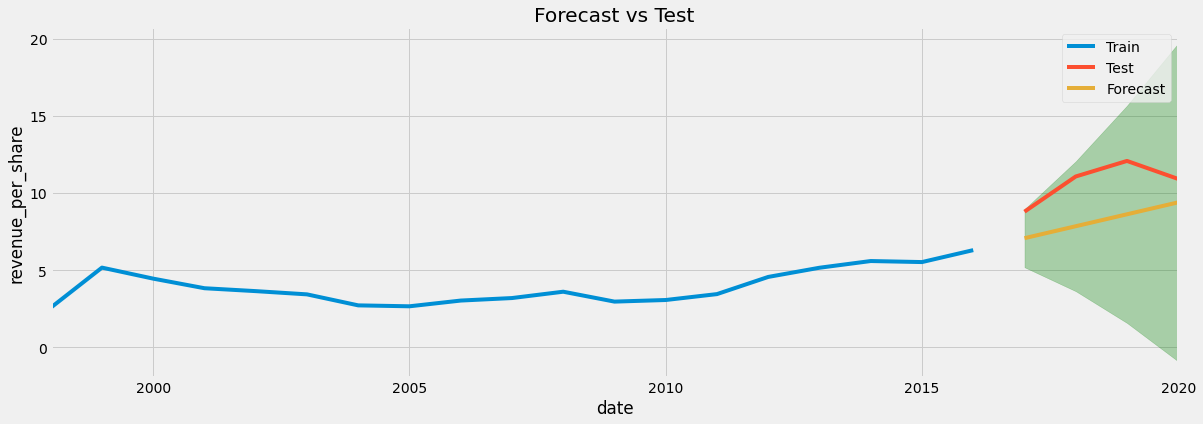

In [508]:
#create and evaluate the auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_17272, 
                                            ts_col='revenue_per_share', 
                                            test_size=4, d=2, auto=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   17
Model:               SARIMAX(2, 2, 0)   Log Likelihood                 -20.531
Date:                Wed, 30 Jun 2021   AIC                             47.062
Time:                        03:38:37   BIC                             49.186
Sample:                    12-31-1998   HQIC                            47.039
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4325      0.411     -1.052      0.293      -1.239       0.374
ar.L2         -0.3817      0.296     -1.291      0.197      -0.961       0.198
sigma2         0.8796      0.316      2.779      0.005       0.259       1.500
===================================================================================
Ljung-Box (L1) (Q):                   0.87   Jarque-Bera (JB):                10.22
Prob(Q):                              0.35   Prob(JB):                         0.01
Heteroskedasticity (H):               0.15   Skew:                            -1.55
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 2.03
The mean of revenue_per_share is 5.12


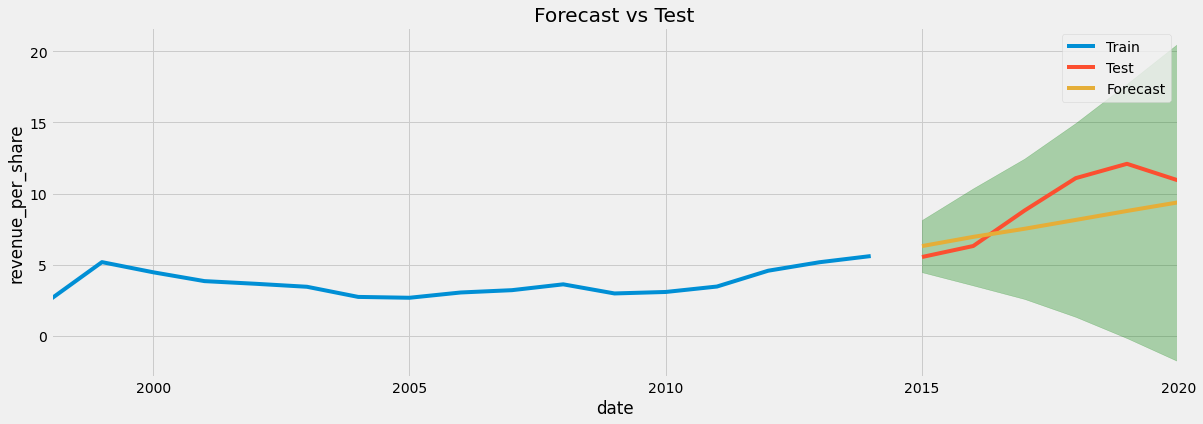

In [509]:
#create and evaluate the manual model
user_model, train, test, user_model_ts = create_eval_model(df=df_model_ts_17272, 
                                            ts_col='revenue_per_share', 
                                            test_size=6, auto=False, order=(2,2,0))

> **OBSERVATIONS**
> - The auto-arima model ARIMA (0,2,0) had a MSE of 2.63 with a 4 year test size. The manual model ARIMA (2,2,0) has a MSE of 2.03 with a 6 year test size.

> **ACTIONS**
> - I will proceed with the auto ARIMA (0,2,0) because it utilizes more training data.

### Model Forecast

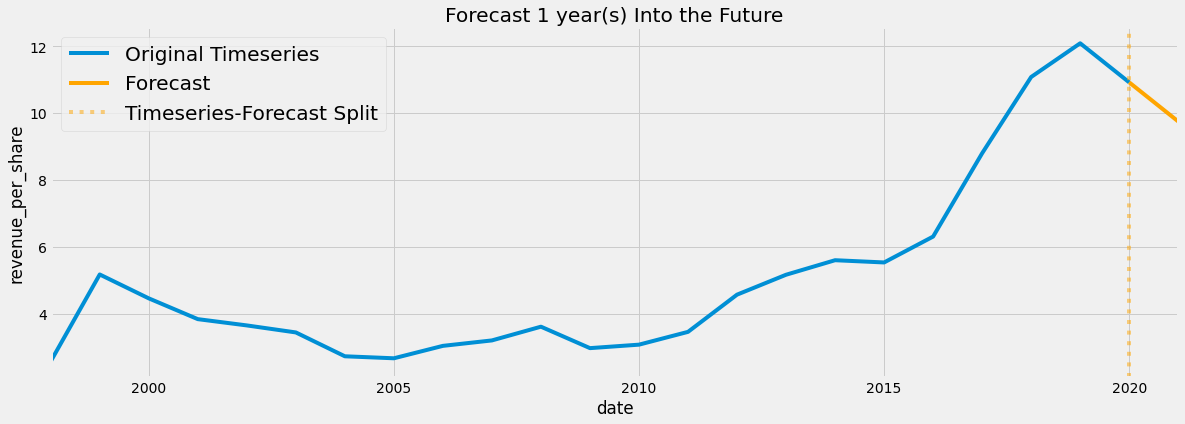



The percent change 1 year(s) into the future is -10.71%


In [510]:
#forecast 1 year into the future and save percent change
percent_change_17272 = forecast(df_model_ts_17272, ts_col='revenue_per_share', 
                               best_model_ts=auto_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - I am not sure why the trend is downward if the forecast was positive?
> - The model forecasts a 10.71% decrease in revenue per share between 2020 and 2021.

## Model Symbol ID 7134

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2005-12-31,7134,"1,391.154",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO
2006-12-31,7134,"1,500.3770000000002",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO
2007-12-31,7134,"1,597.5710000000001",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO
2008-12-31,7134,"1,506.056",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO
2009-12-31,7134,"1,384.751",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO
2010-12-31,7134,"1,315.1789999999999",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO
2011-12-31,7134,"1,314.355",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO
2012-12-31,7134,"1,331.266",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO
2013-12-31,7134,"1,254.655",Data Communications Management Corp,Specialty Business Services,Toronto,Industrials,CA,DCM.TO


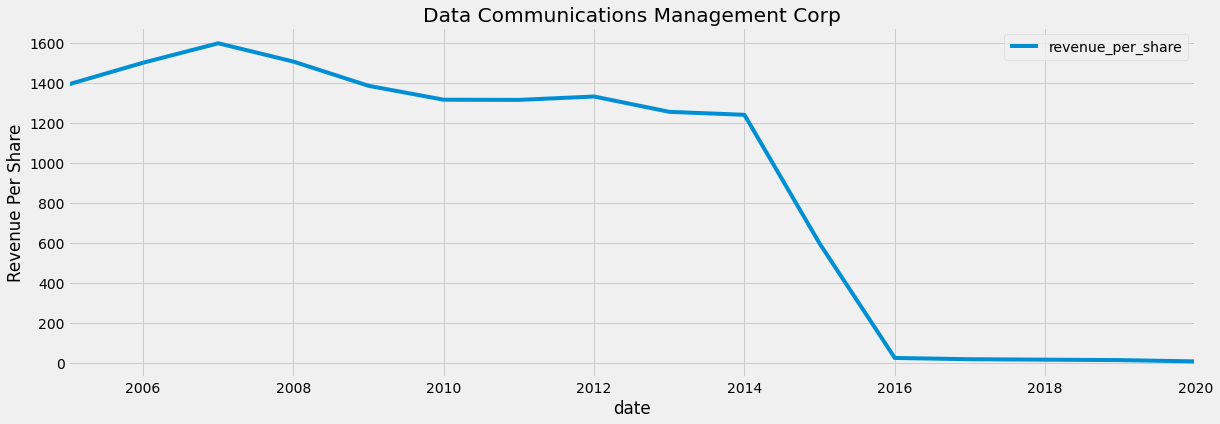

In [511]:
#create dataframe and plot
df_model_ts_7134 = timeseries_creation(df_model_ts, '7134')

### Seasonality & Stationarity

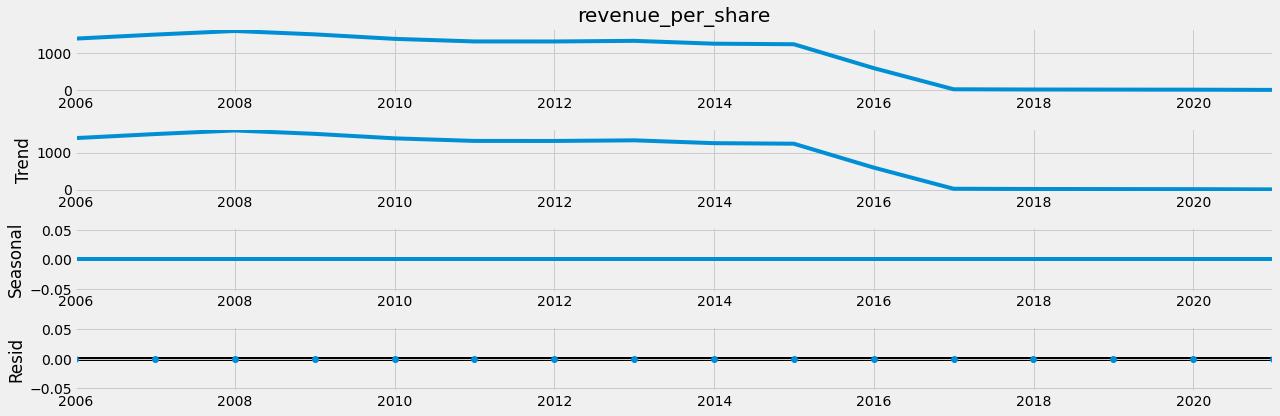

Augmented Dickey-Fuller Test Results
ADF test statistic   0.8053166718370683
p-value              0.9917215061443032
# lags used                         5.0
# observations                     10.0


The data is not stationary


In [512]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_7134['revenue_per_share'])

> **OBSERVATIONS**
> - ADFuller Test shows data is not stationary and there is no seasonality.

> **ACTIONS**
> - I will manually explore differencing if auto-arima doesn't apply it.

### Model Creation & Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   13
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -77.025
Date:                Wed, 30 Jun 2021   AIC                            156.049
Time:                        03:38:39   BIC                            156.447
Sample:                    12-31-2005   HQIC                           155.798
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.072e+04   2.21e+04      3.205      0.001    2.75e+04    1.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.82   Prob(JB):                         0.49
Heteroskedasticity (H):              18.44   Skew:                            -0.24
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 7.26
The mean of revenue_per_share is 906.5


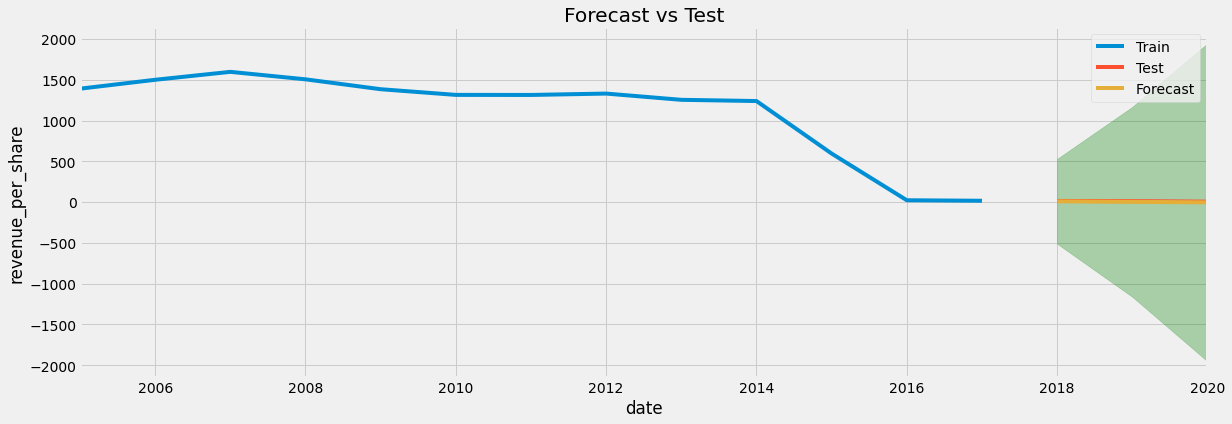

In [513]:
#create and evaluate auto model
auto_model = create_eval_model(df=df_model_ts_7134, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, 
                                            auto=True, d=2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   13
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -81.936
Date:                Wed, 30 Jun 2021   AIC                            167.873
Time:                        03:38:39   BIC                            168.843
Sample:                    12-31-2005   HQIC                           167.514
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4804      0.214      2.244      0.025       0.061       0.900
sigma2      4.928e+04   1.27e+04      3.869      0.000    2.43e+04    7.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.80
Prob(Q):                              0.92   Prob(JB):                         0.05
Heteroskedasticity (H):              17.77   Skew:                            -1.35
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 3.26
The mean of revenue_per_share is 906.5


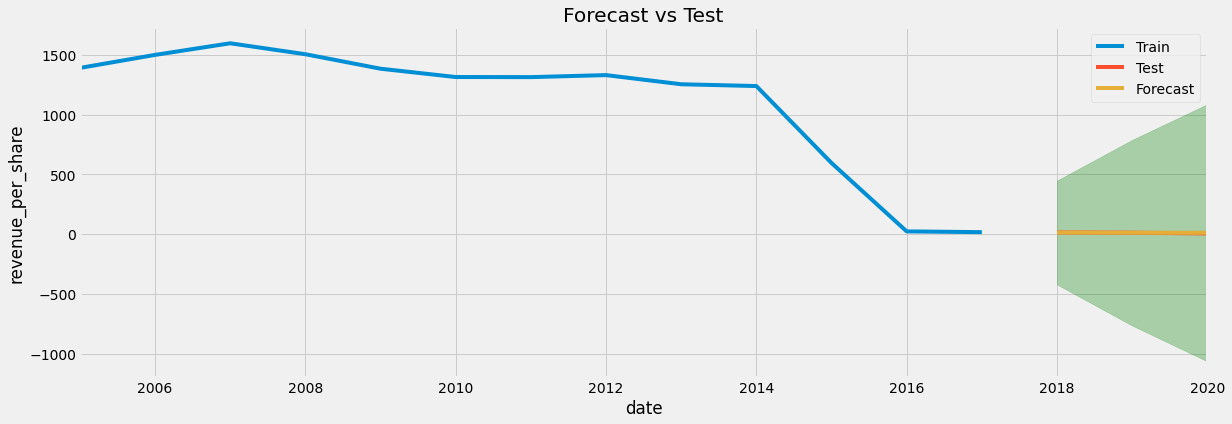

In [514]:
#create and evaluate manual model
user_model, train, test, user_model_ts = create_eval_model(df=df_model_ts_7134, 
                                            ts_col='revenue_per_share', 
                                            test_size=3, 
                                            auto=False, order=(1,1,0))

> **OBSERVATIONS**
> - The auto-arima model suggested an ARIMA (0,2,0) which gave a MSE of 7.26 with a test size of 3 years. I manually created an ARIMA (1,1,0) which gave a MSE of 3.26 with a test size of 3 years. The more recent volatility makes this forecast difficult

> **ACTIONS**
> - I will forecast using the user ARIMA (1,1,0) model because it performed better

### Model Forecast

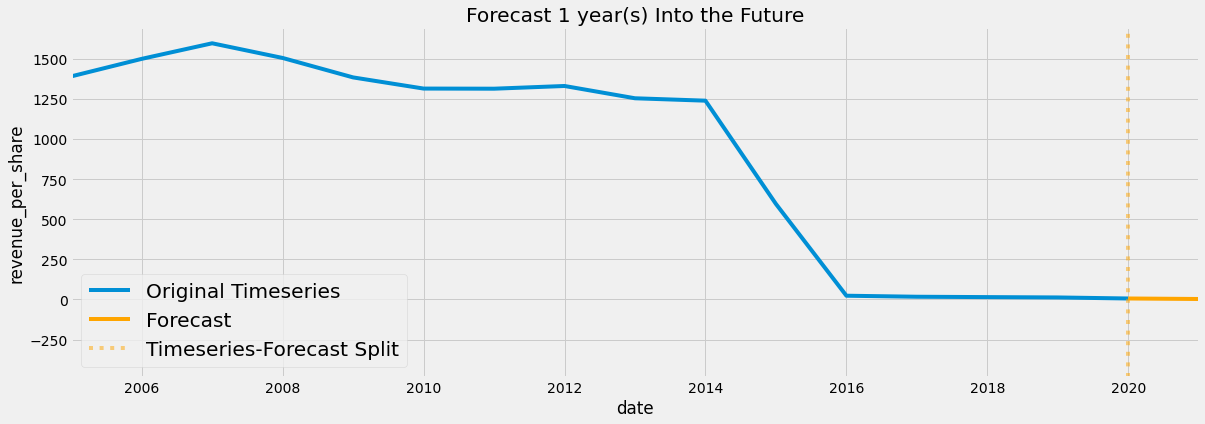



The percent change 1 year(s) into the future is -52.25%


In [515]:
#forecast 1 year into the future and save the percent change
percent_change_7134 = forecast(df_model_ts_7134, ts_col='revenue_per_share', 
                                best_model_ts=user_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - The model forecasts a 52.25% decrease in reveneue per share between 2020 and 2021

## Model Symbol ID 343

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2005-12-31,343,0.43200000000000005,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2006-12-31,343,0.511,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2007-12-31,343,0.52,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2008-12-31,343,0.56,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2009-12-31,343,0.359,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2010-12-31,343,0.387,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2011-12-31,343,0.32899999999999996,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2012-12-31,343,0.341,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK
2013-12-31,343,0.37799999999999995,Softpower International Limited,Home Improvement Retail,HKSE,Consumer Cyclical,HK,0380.HK


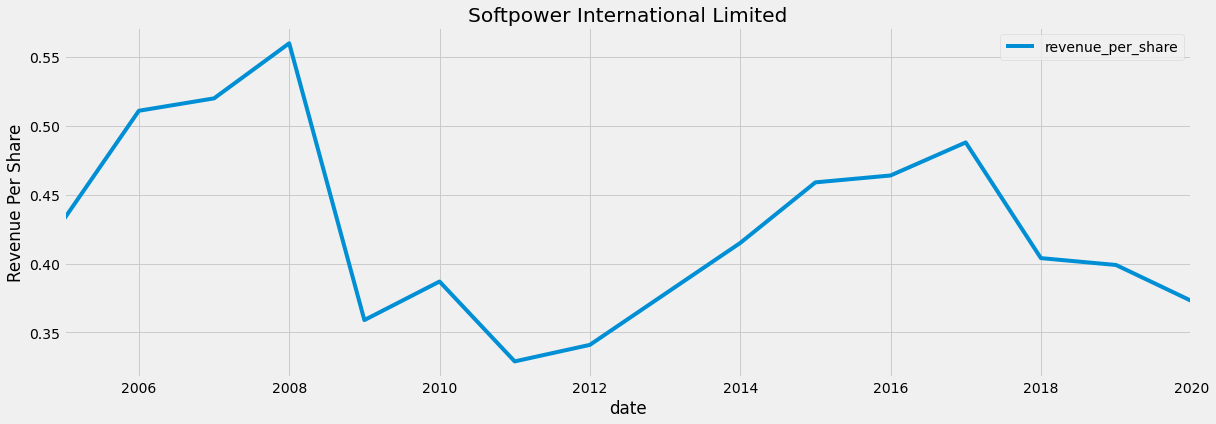

In [516]:
#create dataframe and plot
df_model_ts_343 = timeseries_creation(df_model_ts, '343')

### Seasonality & Stationarity

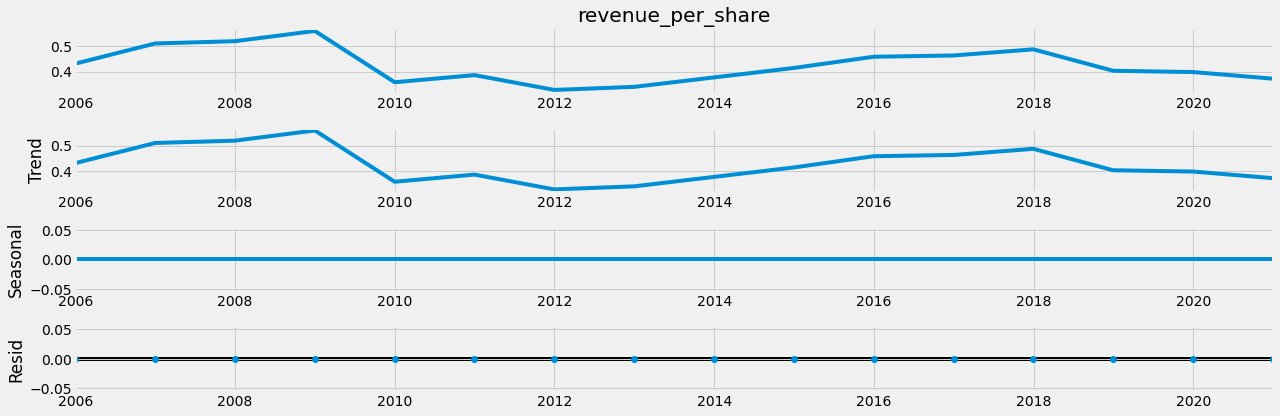

Augmented Dickey-Fuller Test Results
ADF test statistic   -3.0026923123593696
p-value              0.03464373599148855
# lags used                          5.0
# observations                      10.0


The data is stationary


In [517]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_343['revenue_per_share'])

> **OBSERVATIONS**
> - The data is stationary but has no seasonality

### Model Creation & Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   11
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  11.049
Date:                Wed, 30 Jun 2021   AIC                            -18.099
Time:                        03:38:42   BIC                            -17.303
Sample:                    12-31-2005   HQIC                           -18.600
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9855      0.098     10.039      0.000       0.793       1.178
sigma2         0.0057      0.004      1.388      0.165      -0.002       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                10.43
Prob(Q):                              0.71   Prob(JB):                         0.01
Heteroskedasticity (H):               0.42   Skew:                            -1.92
Prob(H) (two-sided):                  0.42   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 0.04
The mean of revenue_per_share is 0.43


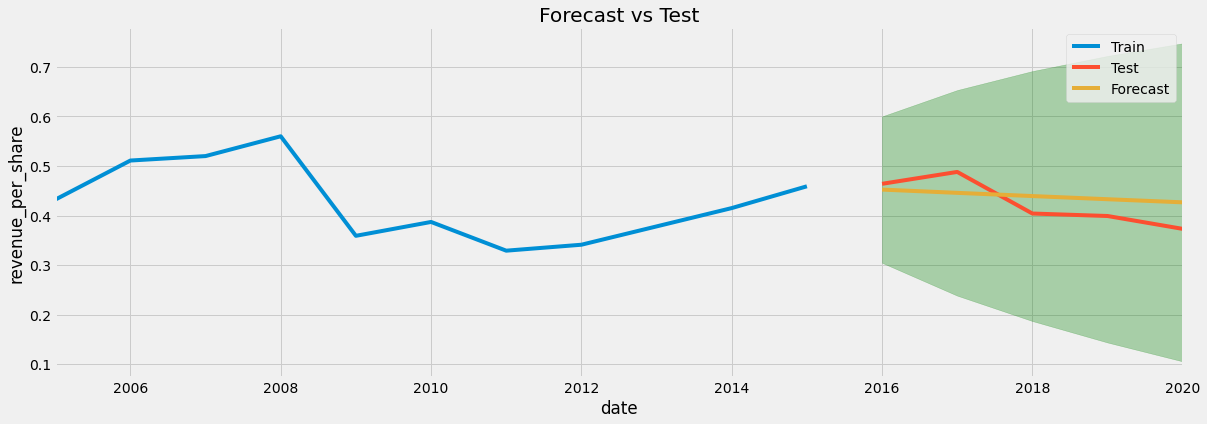

In [518]:
#create and evaluate auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_343, 
                                            ts_col='revenue_per_share', 
                                            auto=True, test_size=5)

> **OBSERVATIONS**
> - The auto arima model suggested an ARIMA (1,0,0) with a MSE of 0.4.

> **ACTIONS**
> - Forecast using the auto ARIMA (1,0,0) model

### Model Forecast

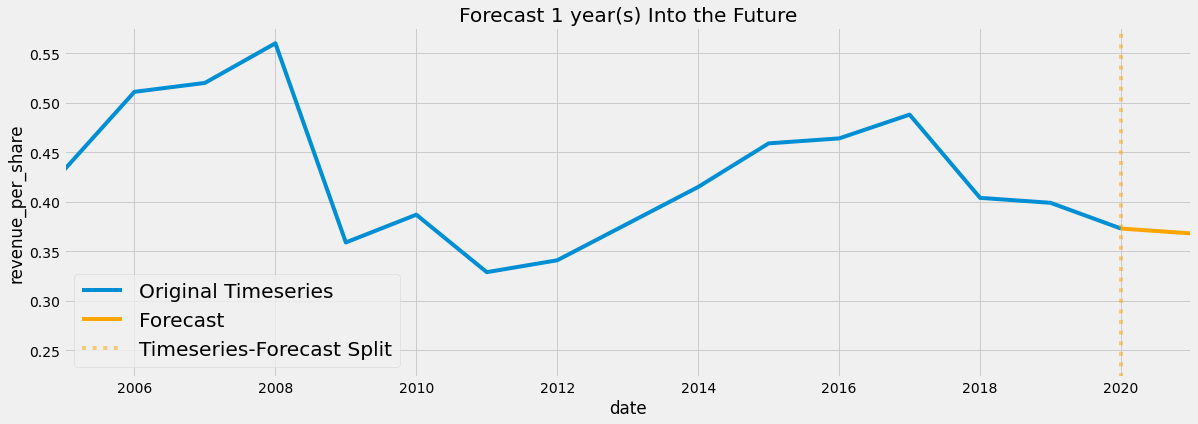



The percent change 1 year(s) into the future is -1.31%


In [519]:
#forecast 1 year into the future
percent_change_343 = forecast(df_model_ts_343, ts_col='revenue_per_share', 
                               best_model_ts=auto_model_ts, forecast_len=0);

> **OBSERVATIONS**
> - The model forecasts a 1.31% decrease in revenue per share between 2020 and 2021.

## Model Symbol ID 9074

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2004-12-31,9074,0.337,"FullNet Communications, Inc.",Telecom Services,Other OTC,Communication Services,US,FULO
2005-12-31,9074,0.354,"FullNet Communications, Inc.",Telecom Services,Other OTC,Communication Services,US,FULO
2006-12-31,9074,0.262,"FullNet Communications, Inc.",Telecom Services,Other OTC,Communication Services,US,FULO
2007-12-31,9074,0.281,"FullNet Communications, Inc.",Telecom Services,Other OTC,Communication Services,US,FULO
2008-12-31,9074,0.259,"FullNet Communications, Inc.",Telecom Services,Other OTC,Communication Services,US,FULO
2009-12-31,9074,0.243,"FullNet Communications, Inc.",Telecom Services,Other OTC,Communication Services,US,FULO
2010-12-31,9074,0.213,"FullNet Communications, Inc.",Telecom Services,Other OTC,Communication Services,US,FULO
2011-12-31,9074,0.225,"FullNet Communications, Inc.",Telecom Services,Other OTC,Communication Services,US,FULO
2012-12-31,9074,0.175,"FullNet Communications, Inc.",Telecom Services,Other OTC,Communication Services,US,FULO


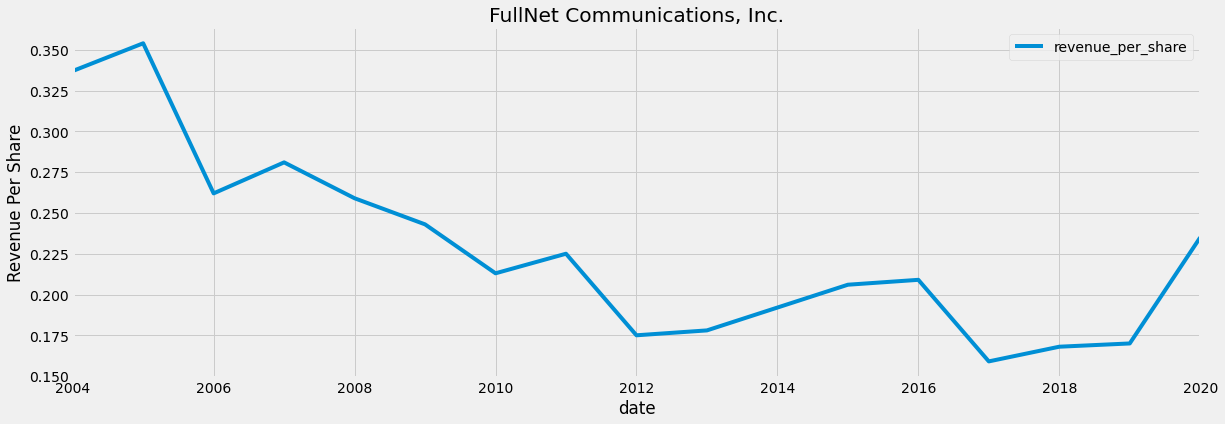

In [520]:
#create dataframe and plot
df_model_ts_9074 = timeseries_creation(df_model_ts, '9074');

### Seasonality & Stationarity

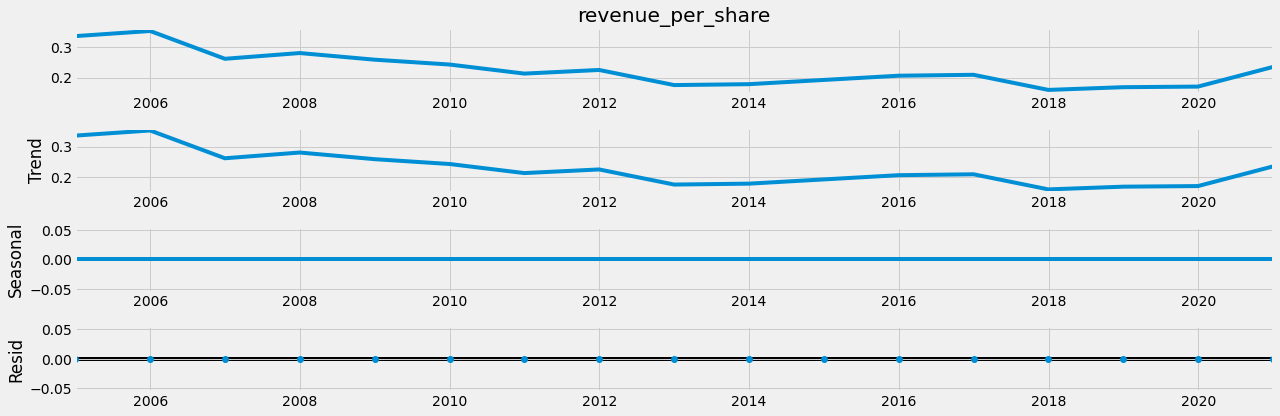

Augmented Dickey-Fuller Test Results
ADF test statistic     -2.19172534458721
p-value              0.20926237536506165
# lags used                          0.0
# observations                      16.0


The data is not stationary


In [521]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_9074['revenue_per_share'])

> **OBSERVATIONS**
> - The data is not stationary and also shows no seasonality

> **ACTIONS**
> - Will manually create a model with differencing if auto-arima doesn't

### Model Creation & Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   12
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  21.412
Date:                Wed, 30 Jun 2021   AIC                            -38.824
Time:                        03:38:45   BIC                            -38.028
Sample:                    12-31-2004   HQIC                           -39.325
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1761      0.994     -0.177      0.859      -2.125       1.773
sigma2         0.0012      0.001      2.043      0.041    4.86e-05       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.16   Prob(JB):                         0.34
Heteroskedasticity (H):               0.33   Skew:                            -1.07
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 0.03
The mean of revenue_per_share is 0.23


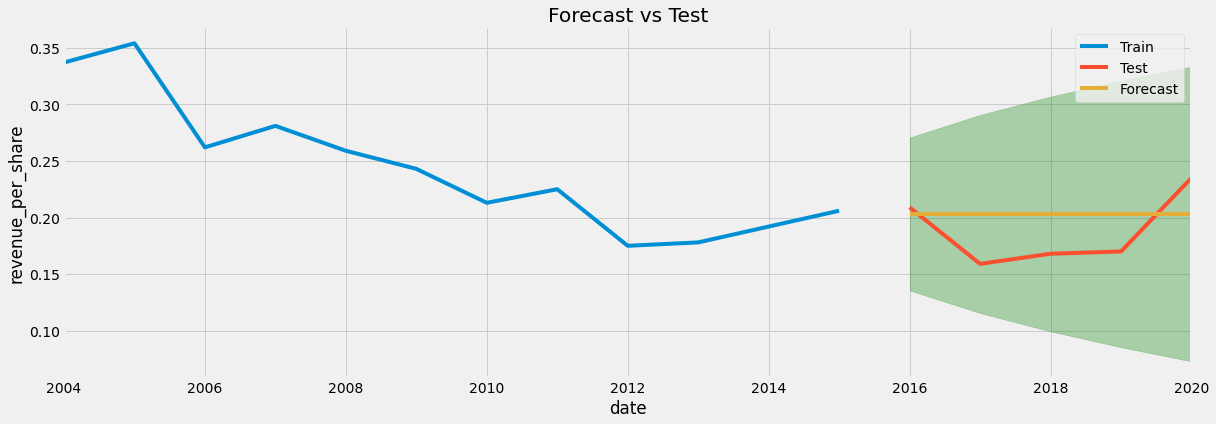

In [522]:
#create and evaluate auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_9074, 
                                            ts_col='revenue_per_share', 
                                            auto=True, test_size=5)

> **OBSERVATIONS**
> - The auto-arima model suggested a ARIMA (0,1,1) with a MSE of .03 for a test size of 5 years.

> **ACTIONS**
> - I will forecast using the auto model

### Model Forecast

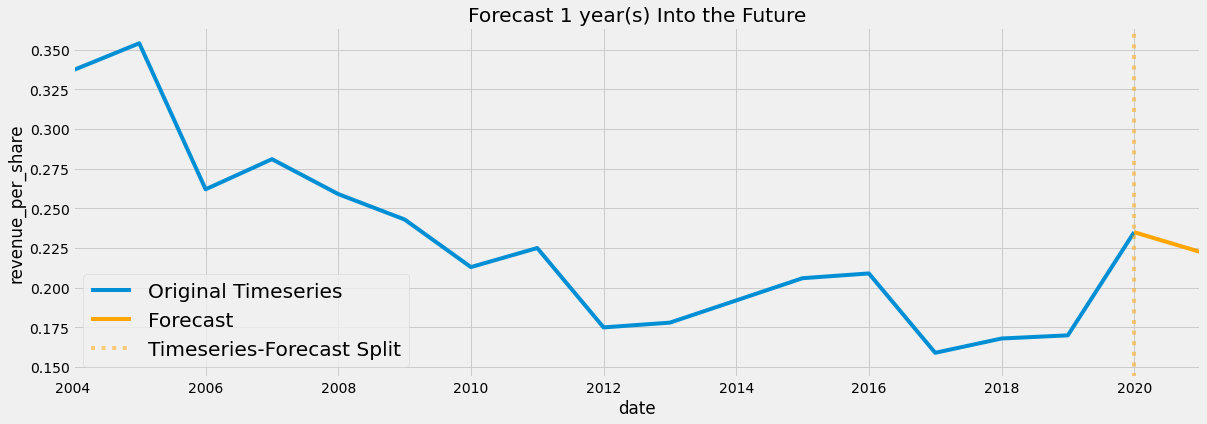



The percent change 1 year(s) into the future is -5.32%


In [523]:
#forecast 1 year into the future and save percent change
percent_change_9074 = forecast(df_model_ts_9074, ts_col='revenue_per_share', 
                               best_model_ts=auto_model_ts, forecast_len=0)

> **OBSERVATIONS**
> - The model forecasts a 5.32% decrease in revenue per share between 2020 and 2021.

## Model Symbol ID 14746

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2000-12-31,14746,7.308,Orapi SA,Specialty Chemicals,Paris,Basic Materials,FR,ORAP.PA
2001-12-31,14746,8.462,Orapi SA,Specialty Chemicals,Paris,Basic Materials,FR,ORAP.PA
2002-12-31,14746,12.5,Orapi SA,Specialty Chemicals,Paris,Basic Materials,FR,ORAP.PA
2003-12-31,14746,16.070999999999998,Orapi SA,Specialty Chemicals,Paris,Basic Materials,FR,ORAP.PA
2004-12-31,14746,16.438,Orapi SA,Specialty Chemicals,Paris,Basic Materials,FR,ORAP.PA
2005-12-31,14746,13.85,Orapi SA,Specialty Chemicals,Paris,Basic Materials,FR,ORAP.PA
2006-12-31,14746,19.2,Orapi SA,Specialty Chemicals,Paris,Basic Materials,FR,ORAP.PA
2007-12-31,14746,26.318,Orapi SA,Specialty Chemicals,Paris,Basic Materials,FR,ORAP.PA
2008-12-31,14746,31.0,Orapi SA,Specialty Chemicals,Paris,Basic Materials,FR,ORAP.PA


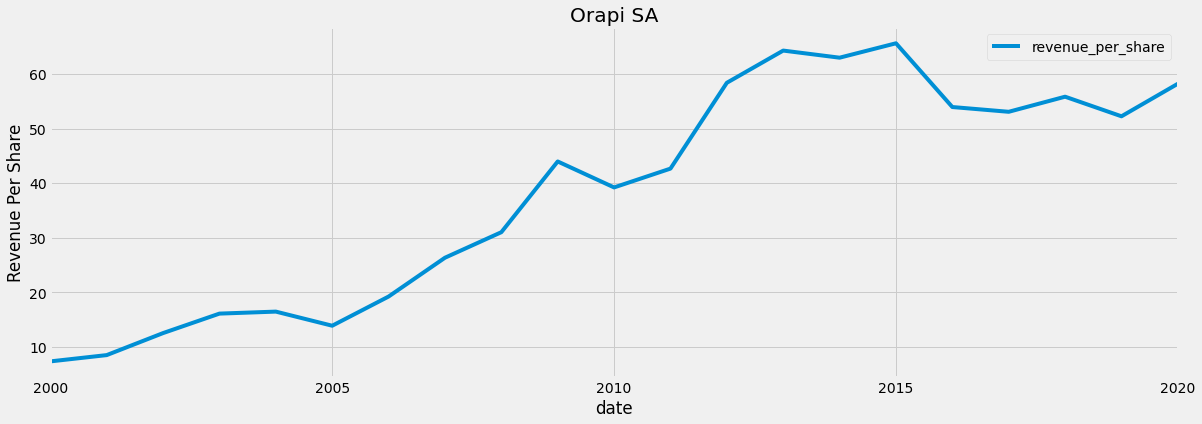

In [524]:
#create dataframe and plot
df_model_ts_14746 = timeseries_creation(df_model_ts, '14746');

### Seasonality & Stationarity

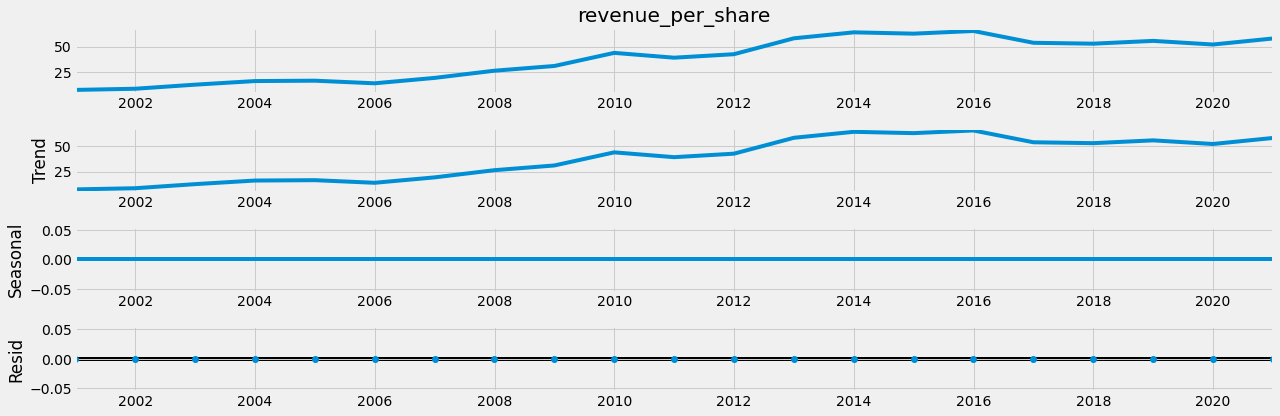

Augmented Dickey-Fuller Test Results
ADF test statistic   -1.1837251567897675
p-value                0.680557265860239
# lags used                          0.0
# observations                      20.0


The data is not stationary


In [525]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_14746['revenue_per_share'])

> **OBSERVATIONS**
> - The data is not stationary and shows no seasonality

### Model Creation & Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   18
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -56.534
Date:                Wed, 30 Jun 2021   AIC                            115.067
Time:                        03:38:48   BIC                            115.900
Sample:                    12-31-2000   HQIC                           115.150
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        45.2917     14.529      3.117      0.002      16.815      73.769
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.75   Prob(JB):                         0.89
Heteroskedasticity (H):               6.51   Skew:                            -0.05
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 3.41
The mean of revenue_per_share is 38.18


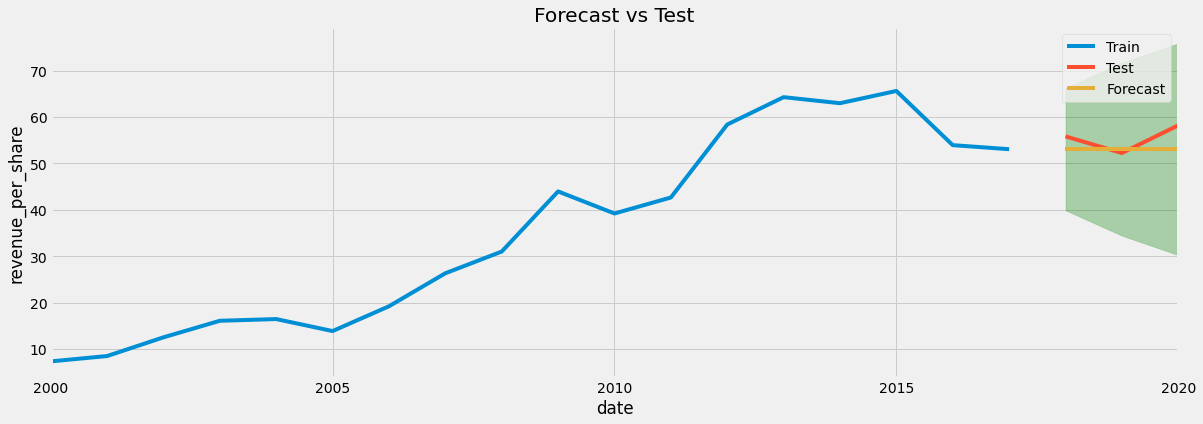

In [526]:
#create and evaluate auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_14746, 
                                            ts_col='revenue_per_share', 
                                            auto=True, test_size=3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   16
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -48.735
Date:                Wed, 30 Jun 2021   AIC                             99.469
Time:                        03:38:48   BIC                            100.108
Sample:                    12-31-2000   HQIC                            99.410
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        61.8235     24.930      2.480      0.013      12.962     110.685
===================================================================================
Ljung-Box (L1) (Q):                   1.99   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.16   Prob(JB):                         0.70
Heteroskedasticity (H):               4.23   Skew:                            -0.54
Prob(H) (two-sided):                  0.14   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 19.17
The mean of revenue_per_share is 38.18


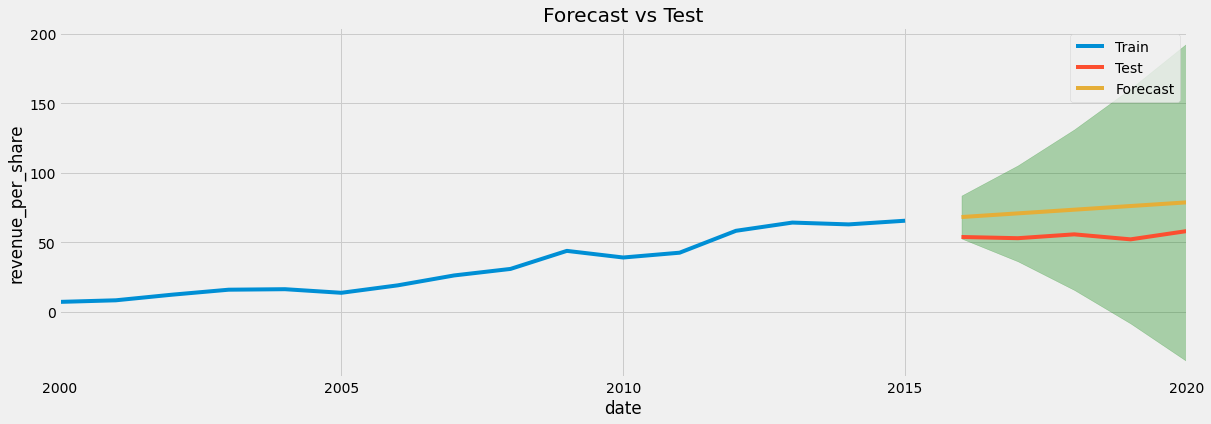

In [527]:
#create and evaluate manual model
user_model, train, test, user_model_ts = create_eval_model(df=df_model_ts_14746, 
                                            ts_col='revenue_per_share', 
                                            auto=False, test_size=5, order=(0,2,0))

> **OBSERVATIONS**
> - The auto-arima model ARIMA (0,1,0) had a MSE of 3.41 with a test size of 3 years. The manual ARIMA (0,2,0) had a much larger MSE for a 5 year test size but forecasts a trend that fits the overall trend better.

> **ACTIONS**
> - Forecast using the user model

### Model Forecast

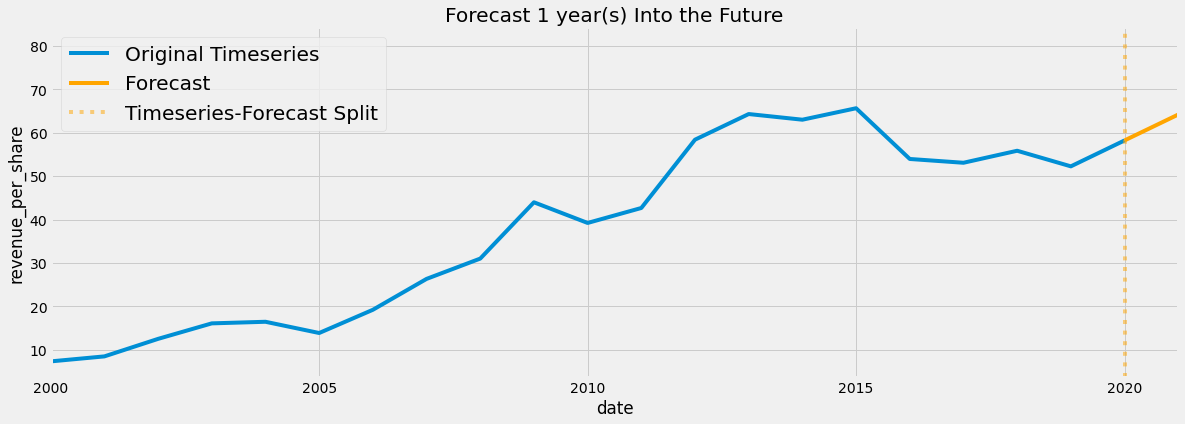



The percent change 1 year(s) into the future is 10.25%


In [528]:
#forecast 1 year into the future and save percent change
percent_change_14746 = forecast(df_model_ts_14746, ts_col='revenue_per_share', 
                               best_model_ts=user_model_ts, forecast_len=0)

> **OBSERVATIONS**
> - The model forecasts a 10.25% increase in revenue per share between 2020 and 2021.

## Model Symbol ID 13554

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
1999-12-31,13554,74.875,Mannatech Inc,Household & Personal Products,Nasdaq Global Select,Consumer Defensive,US,MTEX
2000-12-31,13554,60.132,Mannatech Inc,Household & Personal Products,Nasdaq Global Select,Consumer Defensive,US,MTEX
2001-12-31,13554,52.056999999999995,Mannatech Inc,Household & Personal Products,Nasdaq Global Select,Consumer Defensive,US,MTEX
2002-12-31,13554,56.076,Mannatech Inc,Household & Personal Products,Nasdaq Global Select,Consumer Defensive,US,MTEX
2003-12-31,13554,74.92699999999999,Mannatech Inc,Household & Personal Products,Nasdaq Global Select,Consumer Defensive,US,MTEX
2004-12-31,13554,111.404,Mannatech Inc,Household & Personal Products,Nasdaq Global Select,Consumer Defensive,US,MTEX
2005-12-31,13554,144.269,Mannatech Inc,Household & Personal Products,Nasdaq Global Select,Consumer Defensive,US,MTEX
2006-12-31,13554,154.173,Mannatech Inc,Household & Personal Products,Nasdaq Global Select,Consumer Defensive,US,MTEX
2007-12-31,13554,156.063,Mannatech Inc,Household & Personal Products,Nasdaq Global Select,Consumer Defensive,US,MTEX


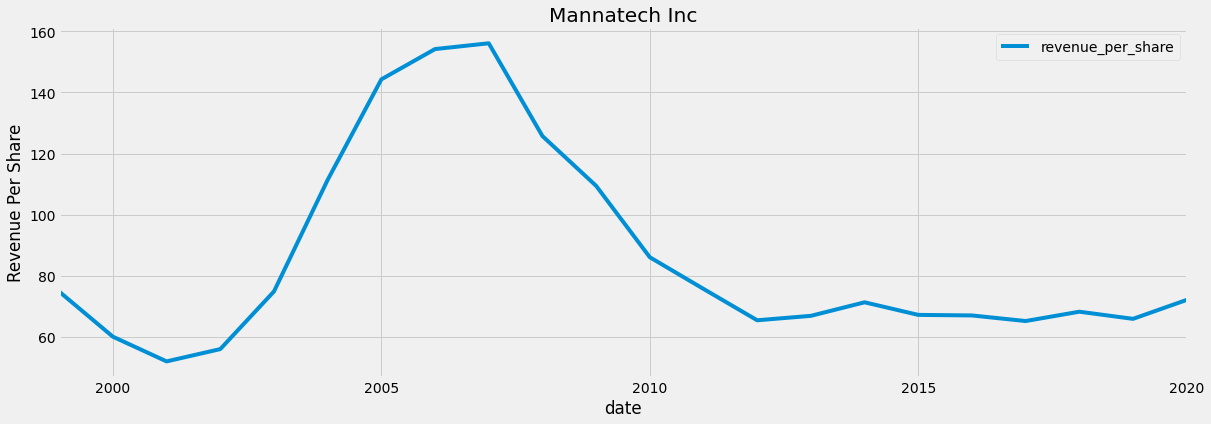

In [529]:
#create dataframe and plot
df_model_ts_13554 = timeseries_creation(df_model_ts, '13554');

### Seasonality & Stationarity

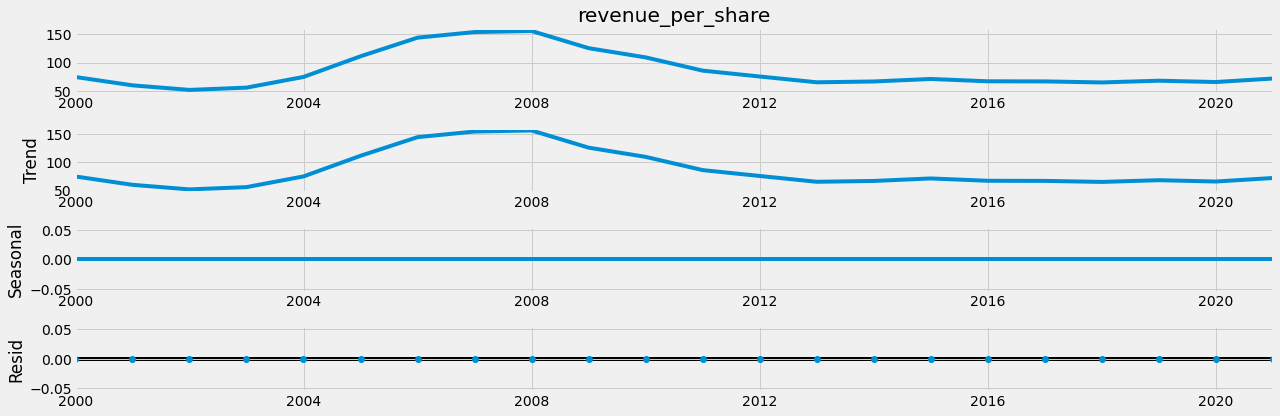

Augmented Dickey-Fuller Test Results
ADF test statistic     -6.5681273146436245
p-value              8.062198833358854e-09
# lags used                            9.0
# observations                        12.0


The data is stationary


In [530]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_13554['revenue_per_share'])

> **OBSERVATIONS**
> - The data is stationary and has no seasonality

### Model Creation & Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   16
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 -65.517
Date:                Wed, 30 Jun 2021   AIC                            139.035
Time:                        03:38:52   BIC                            142.125
Sample:                    12-31-1999   HQIC                           139.193
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5829      0.413      3.835      0.000       0.774       2.392
ar.L2         -0.6145      0.405     -1.517      0.129      -1.409       0.180
ma.L1          0.1392      0.561      0.248      0.804      -0.960       1.238
sigma2       157.9061     81.412      1.940      0.052      -1.658     317.470
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.39
Prob(Q):                              0.99   Prob(JB):                         0.50
Heteroskedasticity (H):               0.55   Skew:                            -0.69
Prob(H) (two-sided):                  0.52   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 8.57
The mean of revenue_per_share is 85.95


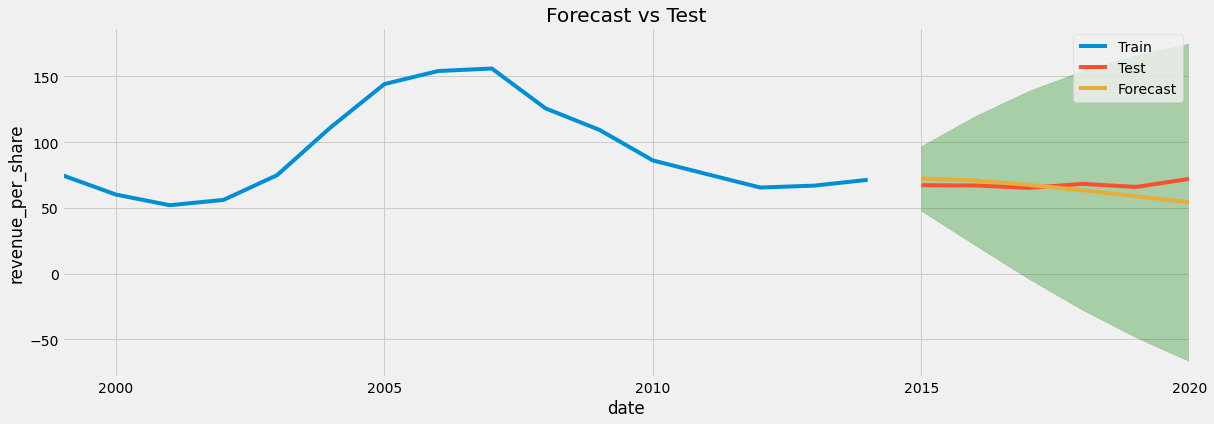

In [531]:
#create and evaluate auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_13554, 
                                            ts_col='revenue_per_share', 
                                            auto=True, test_size=6)

> **OBSERVATIONS**
> - The auto-arima model ARIMA (2,0,1) has a MSE of 8.57 with a test size of 6 years.

> **ACTIONS**
> - Forecast with the auto ARIMA (2,0,1)

### Model Forecast

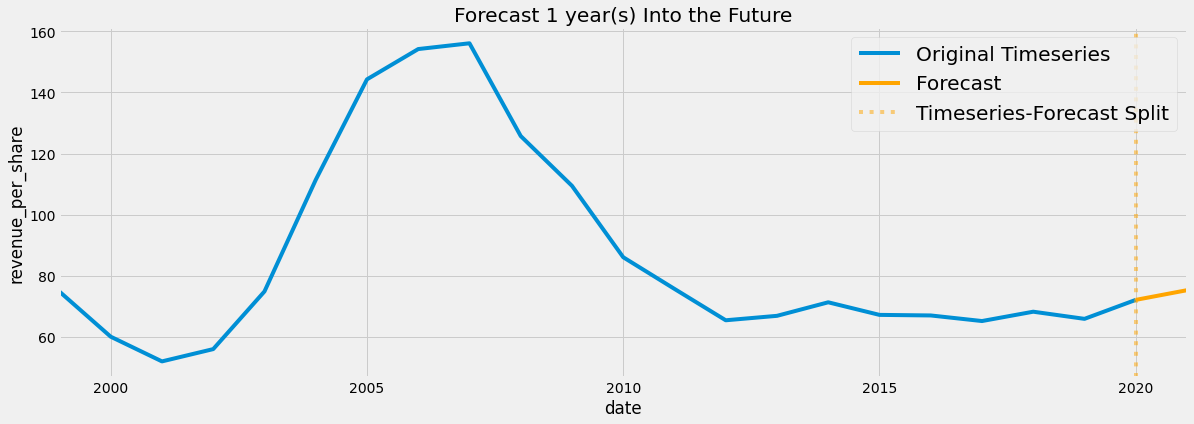



The percent change 1 year(s) into the future is 4.39%


In [532]:
#forecast 1 year into the future and save percent change
percent_change_13554 = forecast(df_model_ts_13554, ts_col='revenue_per_share', 
                               best_model_ts=auto_model_ts, forecast_len=0)

> **OBSERVATIONS**
> - The model forecasts a 6.25% increase in revenue per share between 2020 and 2021.

## Model Symbol ID 18302

,symbol_id,revenue_per_share,company_name,industry,exchange,sector,country,symbol
date,,,,,,,,
2006-12-31,18302,4.702,Supremex Inc,Packaging & Containers,Toronto,Consumer Cyclical,CA,SXP.TO
2007-12-31,18302,6.0089999999999995,Supremex Inc,Packaging & Containers,Toronto,Consumer Cyclical,CA,SXP.TO
2008-12-31,18302,6.2170000000000005,Supremex Inc,Packaging & Containers,Toronto,Consumer Cyclical,CA,SXP.TO
2009-12-31,18302,5.6739999999999995,Supremex Inc,Packaging & Containers,Toronto,Consumer Cyclical,CA,SXP.TO
2010-12-31,18302,5.226,Supremex Inc,Packaging & Containers,Toronto,Consumer Cyclical,CA,SXP.TO
2011-12-31,18302,4.9110000000000005,Supremex Inc,Packaging & Containers,Toronto,Consumer Cyclical,CA,SXP.TO
2012-12-31,18302,4.51,Supremex Inc,Packaging & Containers,Toronto,Consumer Cyclical,CA,SXP.TO
2013-12-31,18302,4.453,Supremex Inc,Packaging & Containers,Toronto,Consumer Cyclical,CA,SXP.TO
2014-12-31,18302,4.563,Supremex Inc,Packaging & Containers,Toronto,Consumer Cyclical,CA,SXP.TO


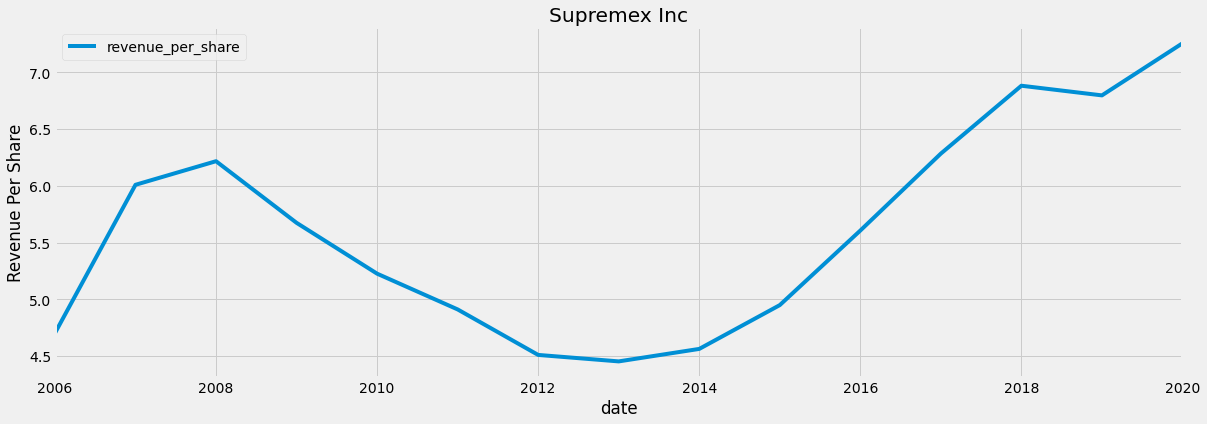

In [533]:
#create dataframe and plot
df_model_ts_18302 = timeseries_creation(df_model_ts, '18302');

### Seasonality & Stationarity

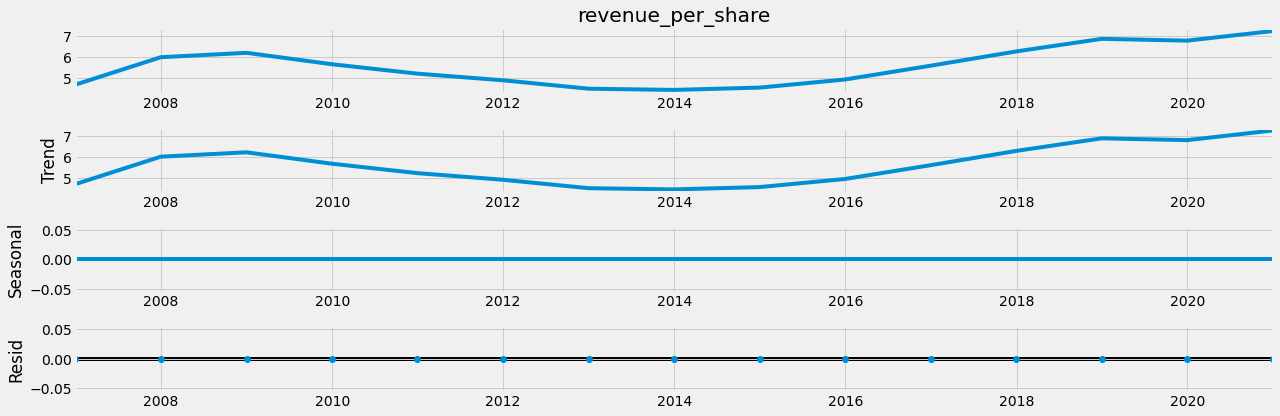

Augmented Dickey-Fuller Test Results
ADF test statistic   -2.4652924628518673
p-value              0.12414899974794497
# lags used                          5.0
# observations                       9.0


The data is not stationary


In [534]:
#check for seasonality and stationarity
seasonality_stationarity_check(df_model_ts_18302['revenue_per_share'])

> **OBSERVATIONS**
> - The data is not stationary and has no seasonality

> **ACTIONS**
> - Evaluate differencing if the auto-arima model does not

### Model Creation & Evaluation

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      revenue_per_share   No. Observations:                   12
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -10.122
Date:                Wed, 30 Jun 2021   AIC                             26.243
Time:                        03:38:56   BIC                             27.698
Sample:                    12-31-2006   HQIC                            25.705
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7759      0.178      9.976      0.000       1.427       2.125
ar.L2         -0.7916      0.212     -3.735      0.000      -1.207      -0.376
sigma2         0.1916      0.136      1.408      0.159      -0.075       0.458
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.49   Prob(JB):                         0.56
Heteroskedasticity (H):               0.25   Skew:                            -0.76
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



The error of this model is 0.18
The mean of revenue_per_share is 5.6


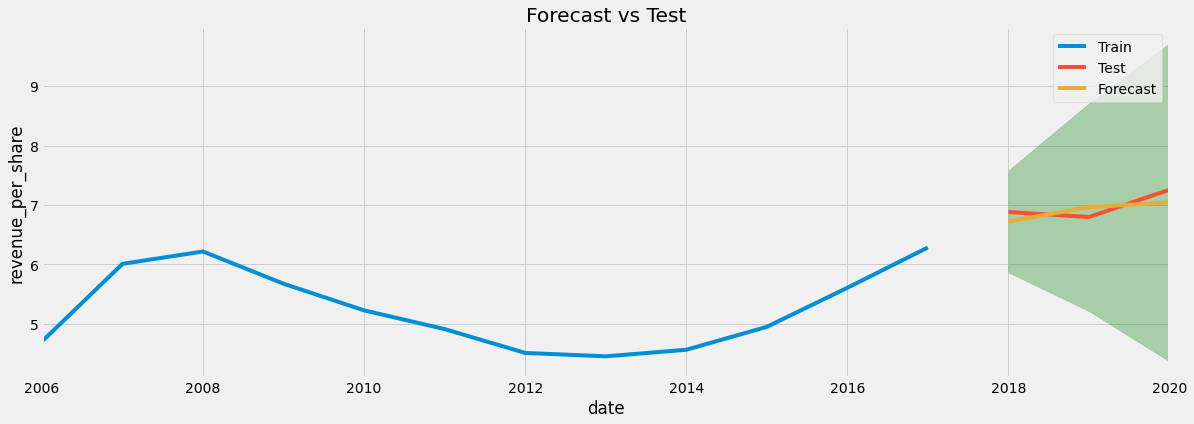

In [535]:
#create and evaluate auto model
auto_model, train, test, auto_model_ts = create_eval_model(df=df_model_ts_18302, 
                                            ts_col='revenue_per_share', 
                                            auto=True, test_size=3)

> **OBSERVATIONS**
> - Auto-arima model ARIMA (2,0,0) has a MSE of 0.18 with a 3 year test size

> **ACTIONS**
> - Forecast using the auto ARIMA (2,0,0) model

### Model Forecast

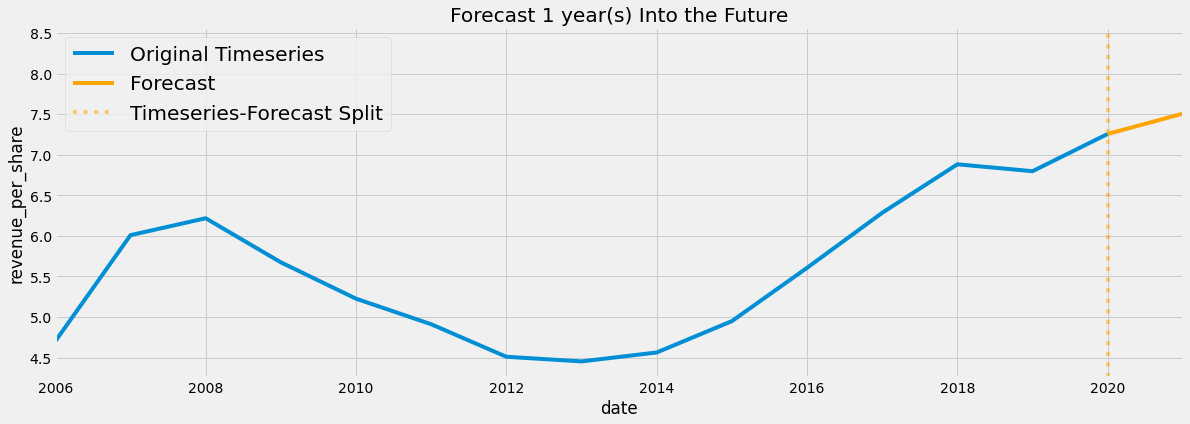



The percent change 1 year(s) into the future is 3.45%


In [536]:
#forecast 1 year into the future and save percent change
percent_change_18302 = forecast(df_model_ts_18302, ts_col='revenue_per_share', 
                               best_model_ts=auto_model_ts, forecast_len=0)

> **OBSERVATIONS**
> - The model forecasts a 3.45% increase in revenue per share between 2020 and 2021.

# DATA INTERPRETATION

In [537]:
#create growth dataframe to rank top 10 value stocks
growth_list = [percent_change_19264, percent_change_10161, percent_change_6760, percent_change_17272,
               percent_change_7134, percent_change_343,percent_change_9074, 
               percent_change_14746, percent_change_13554, percent_change_18302]

growth_df = pd.DataFrame(growth_list, columns=['1_year_growth_percentage'], 
                         index=['19264', '10161','6760', '17272', '7134', '343', 
                                '9074', '14746', '13554', '18302'])


#grab top 10 value stocks
df_top_10 = df_clean.loc[:9]
df_top_10.set_index(df_top_10['symbol_id'], inplace=True)
df_top_10.drop(columns='symbol_id', inplace=True)

#merge value and growth dataframes
df_top_10 = df_top_10.merge(growth_df, left_index=True, right_index=True)

#set action based on value and growth
df_top_10.index.name = 'symbol_id'
df_top_10.reset_index(inplace=True)
df_top_10.loc[df_top_10['1_year_growth_percentage'] > 0, ['final_action']] = 'Buy'
df_top_10.loc[df_top_10['1_year_growth_percentage'] <= 0, ['final_action']] = 'Hold'

#update revenue per share value for symbol_id 19264
df_top_10.loc[df_top_10['symbol_id'] == '19264', 'revenue_per_share'] = 15.70

#set up dataframe
df_top_10[['symbol_id', 'revenue_per_share','1_year_growth_percentage',
           '2020_value_ranking','final_action']].sort_values(['final_action'])

,symbol_id,revenue_per_share,1_year_growth_percentage,2020_value_ranking,final_action
0,19264,15.7,4.34,1,Buy
1,10161,81.58,8.37,2,Buy
7,14746,58.22,10.25,8,Buy
8,13554,72.17,4.39,9,Buy
9,18302,7.26,3.45,10,Buy
2,6760,3.58,-5.35,3,Hold
3,17272,10.92,-10.71,4,Hold
4,7134,6.01,-52.25,5,Hold
5,343,0.37,-1.31,6,Hold
6,9074,0.24,-5.32,7,Hold


HIT Investments was interested in understanding how the top value stocks have grown over time which was the focus of this analysis. Utilizing each stocks Revenue per share over time has given additional insights beyond the just the value rank. Through the analysis, each of the top 10 value stocks was modeled with respect to each stocks individual history of revenue per share. Both the auto-arima function as well as a manual modeling approach was utilized in order to find the best fitting forecast to the overall performance of the stock. Each stock's best model was used to forecast revenue per share 1 year into the future. The percent difference between the most recent value (last value in the time series for each stock) and the forecasted endpoint provides insight into future growth potential of the stock. A 1 year percentage change in revenue per share metric was utilized in order to determine the growth ranking of each stock. This can be changed to any timeframe based on the needs of the analysis. The results show that 5 of the stocks have a predicted positive growth 1 year into the future and 5 stocks have a predicted negative growth 1 year into the future.


# RECOMMENDATIONS AND CONCLUSIONS

In conclusion, utilzing time series modeling to investigate the growth of high value stocks to gain additional insight on its overall performance has shown to be helpful in truly understanding which stocks could be a good addition to an investment portfolio. 

The top 10 value stocks, shown below, have a very different growth rates and thefore sparking a different action:

| Symbol ID | Revenue Per Share | 1 Year Growth Rate | 2020 Value Ranking | Final Action |
|-----------|-------------------|--------------------|--------------------|--------------|
| 19264     |\$15.7             |4.34%               |1                   | Buy          |
| 10161     |\$81.58            |8.37%               |2                   | Buy          |
| 6760      |\$58.22            |10.25%              |8                   | Buy          |
| 17272     |\$72.17            |4.39%               |9                   | Buy          |
| 7134      |\$7.26             |3.45%               |10                  | Buy          | 
| 343       |\$3.58             |-5.35%              |3                   | Hold         |
| 9074      |\$10.92            |-10.71%             |4                   | Hold         |
| 14746     |\$6.01             |-52.25%             |5                   | Hold         |
| 13554     |\$0.37             |-1.31%              |6                   | Hold         |
| 18302     |\$0.24             |-5.32%              |7                   | Hold         |

Now that HIT Investments has another meaningful way to analyze stock performance (value and now growth), it is recommended to persue stocks which both rank high for value and have a positive growth rate. Given more time, more stocks should be modeled in order to give a better view of high value stocks which show great future growth potential.